# 人民日报文章月度内容分析

## 1.月度关键词对比分析

In [1]:
import multiprocessing
import os
import time
import jieba
import re
from zhon.hanzi import punctuation as puncZH
from string import punctuation as puncEN
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 全局配置
encoding = 'utf-8'
global_path = '../datas_contrast/'
font_path = '../Fonts/方正正中黑简体.ttf' 
width=9000
height=6000
punctuation_set = set(puncZH + puncEN)


def get_news_path(year_month):
    """
      获取路径下的全部文章内容
    :param year_month: 年月
    :return: 全部文章的路径 
    """
    news_path = []
    for dirname, _, filenames in os.walk(global_path + year_month):
        for filename in filenames:
            news_path.append(os.path.join(dirname, filename).replace('\\', '/'))
    print("func get_news_path() is called：文件夹{}中现有新闻总数为: {}".format(year_month, len(news_path)))
    return news_path


def remove_punctuation(s: str):
    """
        去除标点符号    
    :param s: 传入的字符串
    :return: 去除标点符号后的字符串
    """
    s = re.sub(r"[%s]+" % puncZH, "", s)
    s = re.sub(r"[%s]+" % puncEN, "", s)
    s = re.sub(r"[\d\n\t\r]+", "", s)
    return s


def has_punctuation(s: str):
    """
        判断字符串中是否存在标点符号        
    :param s: 传入的字符串
    :return: bool标识
    """
    return any(char in punctuation_set for char in s)


def get_words(news: str):
    """
        获取某路径下某个文章内的全部词语
    :param news: 
    :return: 
    """
    split_news = jieba.lcut(news)  # 采用精确模式进行分词
    removed_split_news = []
    for text in split_news:
        if has_punctuation(text) is False:
            removed_split_news.append(text)
    return removed_split_news


def get_words_count(news_path):
    """
        获取全部文章的全部词语
    :param news_path: 
    :return: 
    """
    words = []
    for path in news_path:
        with open(path, 'r', encoding=encoding) as file:
            news = file.read()
            words.extend(get_words(news))
    print('func get_words_count() is called：词语数量: ', len(words))
    return words


from collections import Counter


def get_unique_words_count(words):
    """
        统计某个词语的词频信息
    :param words: 词语列表
    :return: 词语词频的字典
    """
    word_count = Counter(words)  # 使用collections.Counter来更简洁地统计词频
    print('func get_unique_words_count() is called：去重词语的个数：', len(word_count))
    return word_count


def get_stop_words():
    """
        获取停用词
    :return: 
    """
    stopwords = set()
    for dirname, _, filenames in os.walk('../stopwords-master'):
        for filename in filenames:
            if filename.endswith('txt'):
                try:
                    with open(os.path.join(dirname, filename), 'r', encoding='utf-8') as file:
                        stopwords.update(file.read().split())
                except UnicodeDecodeError as e:
                    print(f"UnicodeDecodeError: {dirname,filename}{e}")
                # 在这里处理异常，如忽略或记录错误
    
    common_stopwords = {'年', '月', '日', '上', '中', '本报', '的', '和', '在', '为', '了', '\xa0', '\n', ' ', '■', '是'}
    stopwords.update(common_stopwords)
    stopwords = list(stopwords)
    print('func get_unique_words_count() is called：统计停用词总数: ', len(stopwords))
    return stopwords


def word_count_remove_stopword(word_count):
    """
        从全部词语中移除停用词
    :param word_count: 
    :return: 
    """
    stopwords = set(get_stop_words())
    word_count = {word: count for word, count in word_count.items() if word not in stopwords}
    print('func get_unique_words_count() is called：不带停用词的唯一单词总数: ', len(word_count))
    word_count_no_single = {word: count for word, count in word_count.items() if len(word) > 1 }
    print('func get_unique_words_count() is called：去除单个字的唯一单词总数: ', len(word_count_no_single))
    return word_count_no_single


def timer_process():
    """
        计时器，用于计时生成词云图所用时间
    :return: 
    """
    start_time = time.time()
    while True:
        current_time = time.time()
        elapsed_time = current_time - start_time
        print(f"词云图生成时间计时，当前已经用时: {int(elapsed_time)} 秒", end='\r')
        time.sleep(1)


def draw_wordcloud(word_count):
    """
        生成词云图并保存
    :param word_count: 词频字典
    :param font_path: 字体路径
    :param width: 图片宽度
    :param height: 图片高度
    """
    start_time = time.time()
    print("开始初始化WordCloud init")
    wc = WordCloud(font_path=font_path, width=width, height=height, background_color="red",
                   max_words=1000,
                   color_func=lambda *args, **kwargs: (255, 255, 0))
    print("初始化完成! 开始生成WordCloud图片!预计400秒")
    timer = multiprocessing.Process(target=timer_process)
    timer.start()
    wc.generate_from_frequencies(word_count)
    # 主进程执行完毕后，关闭计时进程
    timer.terminate()
    timer.join()
    print("生成图片完成! 开始保存图片!")
    wc.to_file("People's Daily WordCloud Zh_1.png")
    plt.figure(figsize=(32, 16))
    plt.imshow(plt.imread("./People's Daily WordCloud Zh_1.png"))
    plt.axis("off")
    plt.show()
    print(f"代码块执行时间：{time.time() - start_time} 秒")


def get_current_data_list():
    """
        获取当前现有文章
    :param global_path: 
    :return: 
    """
    local_data = []
    for dirname, _, filenames in os.walk(global_path):
        if global_path == dirname:
            continue  # 跳过根路径
        local_data.append(int(dirname.replace(global_path, '')))
    local_data.sort()
    print('当前已经有的数据有:', local_data)
    return local_data

In [3]:
import pandas as pd

# 针对不同的领域进行分析
category = ['政治与国际关系', '经济与金融', '文化与教育', '社会与人民生活', '科技与创新', '军事与国防',
            '环境与可持续发展', '国内地区报道', '国际报道']
category_keywords_politics = ['政治与国际关系', '政治', '党和政府', '国内政策', '国际外交', '国际合作', '政府工作',
                              '政治改革', '政治动态', '政权', '外交政策', '政府机构', '党派政治', '领导人', '政治体制',
                              '政治制度', '政治经济', '政治发展', '政治体制', '外交', '外交政策', '外交动态',
                              '外交事务', '外交动态', '外交事务', '习近平']
category_keywords_economy = ['经济与金融', '经济', '金融', '经济发展', '贸易', '发展', '建设', '金融市场',
                             '宏观经济政策', '产业发展', '经济改革', '经济动态', '经济增长', '经济政策', '经济动态',
                             '经济体制', '经济体制', '经济领域', '经济政策', '经济改革']
category_keywords_culture = ['文化与教育', '文化活动', '艺术', '文化传承', '教育政策', '教育改革', '文化领域',
                             '文化发展', '教育体制', '文化教育', '文化发展', '文化传承', '文化发展', '文化', '教育',
                             '传统文化', '中华文化', '传承', '历史', '学习', '诗词', '弘扬', '故宫', '书法', '博物馆',
                             '国学']
category_keywords_society = ['社会与人民生活', '社会', '人民', '生活', '社会问题', '医疗卫生', '社会保障',
                             '人民生活水平', '社会动态', '社会改革', '社会发展', '社会福利']
category_keywords_science = ['科技与创新', '科技', '创新', '科研发展', '科技政策', '创新技术', '信息技术', '科学研究',
                             '科技领域', '科技创新', '技术发展']
category_keywords_military = ['军事与国防', '国防', '军事', '军事动态', '军事政策', '军事技术', '军队', '国防建设',
                              '军事演习', '军事合作', '官兵', '部队', '战士', '连队', '战友', '战场', '装备', '军人',
                              '强军', '海军', '飞行员', '官兵', '空军', '陆军', '导弹', '武警']
category_keywords_environment = ['环境与可持续发展', '环境', '可持续', '可持续发展', '环保政策', '可持续发展',
                                 '环境保护', '气候变化', '环境污染', '生态保护', '环境政策', '可持续资源利用']
category_keywords_domestic = ['国内地区报道', '国内', '地区', '地方政府工作', '地方动态', '地方经济', '地方政策',
                              '地方社会', '地方文化', '地方发展', '地方改革']
category_keywords_internation = ['国际报道', '国际', '世界', '国际新闻', '国际事务', '国际合作', '国际外交', '国际关系',
                                 '国际经济', '国际政治', '国际动态']
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['simhei']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题


def draw_word_frequency_distribution(word_count):
    """
        画词频分布图
    :param word_count: 词频分布
    :return: 
    """
    word_ds = pd.DataFrame(word_count, index=[0])
    word_ds = word_ds.T
    word_ds.columns = ['count']
    word_ds.sort_values(by=['count'], ascending=False, inplace=True)
    # print(word_ds.head(20))
    word_ds.head(20).plot(kind='bar', figsize=(12, 5), title='人民日报关键词词频统计')
    plt.xlabel('关键词名称')
    plt.xticks(rotation=0)
    plt.ylabel('词频统计')
    plt.legend(['数量'])
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


def draw_word_frequency_changes(a1, a2, a3, a4, a5, flag):
    all_keys = set(a1.keys()).union(set(a2.keys())).union(set(a3.keys())).union(set(a4.keys())).union(set(a5.keys()))
    x = list(all_keys)

    # 取前15个关键词
    if flag == 1:
        month = '07'
        sorted_keys = sorted(x, key=lambda k: a1.get(k, 0), reverse=True)[:15]
    elif flag == 2:
        month = '08'
        sorted_keys = sorted(x, key=lambda k: a2.get(k, 0), reverse=True)[:15]
    elif flag == 3:
        month = '09'
        sorted_keys = sorted(x, key=lambda k: a3.get(k, 0), reverse=True)[:15]
    elif flag == 4:
        month = '10'
        sorted_keys = sorted(x, key=lambda k: a4.get(k, 0), reverse=True)[:15]
    elif flag == 5:
        month = '11'
        sorted_keys = sorted(x, key=lambda k: a5.get(k, 0), reverse=True)[:15]
    else:
        print('flag error')

    y1 = [a1[key] if key in a1 else 0 for key in sorted_keys]
    y2 = [a2[key] if key in a2 else 0 for key in sorted_keys]
    y3 = [a3[key] if key in a3 else 0 for key in sorted_keys]
    y4 = [a4[key] if key in a4 else 0 for key in sorted_keys]
    y5 = [a5[key] if key in a5 else 0 for key in sorted_keys]

    plt.figure(figsize=(12, 5))

    bar_width = 0.15
    index = range(len(sorted_keys))

    plt.bar([i - bar_width * 2 for i in index], y1, bar_width, label='a1')
    plt.bar([i - bar_width for i in index], y2, bar_width, label='a2')
    plt.bar(index, y3, bar_width, label='a3')
    plt.bar([i + bar_width for i in index], y4, bar_width, label='a4')
    plt.bar([i + bar_width * 2 for i in index], y5, bar_width, label='a5')

    plt.xlabel('关键词')
    plt.ylabel('词频')
    plt.title(f'前15条关键字词频变化(以2023年{month}月的关键字为准)')
    plt.xticks(index, sorted_keys)
    plt.legend(['202307', '202308', '202309', '202310', '202311'])
    plt.tight_layout()
    plt.show()


def get_word_frequency_statistics_for_each_field_changes(a1, a2, a3, a4, a5):
    all_keys = set(a1.keys()).union(set(a2.keys())).union(set(a3.keys())).union(set(a4.keys())).union(set(a5.keys()))
    x = list(all_keys)

    y1 = [a1[key] if key in a1 else 0 for key in x]
    y2 = [a2[key] if key in a2 else 0 for key in x]
    y3 = [a3[key] if key in a3 else 0 for key in x]
    y4 = [a4[key] if key in a4 else 0 for key in x]
    y5 = [a5[key] if key in a5 else 0 for key in x]

    plt.figure(figsize=(12, 5))

    bar_width = 0.15
    index = range(len(x))

    plt.bar([i - bar_width * 2 for i in index], y1, bar_width, label='a1')
    plt.bar([i - bar_width for i in index], y2, bar_width, label='a2')
    plt.bar(index, y3, bar_width, label='a3')
    plt.bar([i + bar_width for i in index], y4, bar_width, label='a4')
    plt.bar([i + bar_width * 2 for i in index], y5, bar_width, label='a5')

    plt.xlabel('不同领域的名称')
    plt.ylabel('各个领域所占词频')
    plt.title('不同时期不同领域关键字词频变化')
    plt.xticks(index, x)
    plt.legend(['202307', '202308', '202309', '202310', '202311'])
    plt.tight_layout()
    plt.show()


def get_word_frequency_statistics_for_each_field(word_count, year_month):
    # 创建一个字典，用于存储每个领域的词频统计
    category_word_counts = {}
    # 遍历每个领域的关键词列表
    for category_keywords in [category_keywords_politics, category_keywords_economy, category_keywords_culture,
                              category_keywords_society, category_keywords_science, category_keywords_military,
                              category_keywords_environment, category_keywords_domestic, category_keywords_internation]:
        # 初始化该领域的词频统计
        category_word_count = {}

        # 遍历关键词列表，统计词频
        for keyword in category_keywords:
            # 如果关键词存在于word_count中，将其词频添加到该领域的词频统计中
            if keyword in word_count:
                category_word_count[keyword] = word_count[keyword]

        # 将该领域的词频统计添加到category_word_counts字典中
        category_word_counts[category_keywords[0]] = category_word_count

    category_word_counts_sum = {}
    # 打印每个领域的词频统计
    for category, word_count_ in category_word_counts.items():
        # print(f'{category}词频统计：')
        sum = 0
        for keyword, count in word_count_.items():
            sum += count
            # print(f'{keyword}: {count}')
        category_word_counts_sum[category] = sum
        print()
    # print(category_word_counts_sum)
    # 提取领域和词频数据
    # 创建柱状图
    plt.figure(figsize=(12, 5))
    plt.barh(list(category_word_counts_sum.keys()), list(category_word_counts_sum.values()), color='skyblue')
    plt.xlabel(year_month[:4] + '年' + year_month[4:] + '月' + '词频统计')
    plt.title(year_month[:4] + '年' + year_month[4:] + '月' + '不同领域的词频统计')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.gca().invert_yaxis()  # 逆序显示
    # 显示图表
    plt.show()
    get_word_frequency_statistics_for_each_field_single(category_word_counts)
    return category_word_counts_sum


def get_word_frequency_statistics_for_each_field_single(category_word_counts):
    num_categories = len(category_word_counts)
    fig, axs = plt.subplots(3, 3, figsize=(14, 14))  # 创建一个3x3的子图网格
    categories = list(category_word_counts.keys())

    for i in range(3):
        for j in range(3):
            if i * 3 + j < num_categories:
                category = categories[i * 3 + j]
                word_count = category_word_counts[category]
                axs[i, j].bar(word_count.keys(), word_count.values(), color='skyblue')
                axs[i, j].set_xlabel('词语')
                axs[i, j].set_ylabel('词频')
                axs[i, j].set_title(category)
                axs[i, j].tick_params(axis='x', rotation=45)
                axs[i, j].grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()  # 调整子图之间的间距
    plt.show()

In [4]:
news_path_202307 = get_news_path('202307')
news_path_202308 = get_news_path('202308')
news_path_202309 = get_news_path('202309')
news_path_202310 = get_news_path('202310')
news_path_202311 = get_news_path('202311')

func get_news_path() is called：文件夹202307中现有新闻总数为: 2573
func get_news_path() is called：文件夹202308中现有新闻总数为: 2585
func get_news_path() is called：文件夹202309中现有新闻总数为: 2335
func get_news_path() is called：文件夹202310中现有新闻总数为: 2055
func get_news_path() is called：文件夹202311中现有新闻总数为: 2384


In [6]:
print("文件夹: ..data_contrast/202307/")
words_202307 = get_words_count(news_path_202307)
print("文件夹: ..data_contrast/202308/")
words_202308 = get_words_count(news_path_202308)
print("文件夹: ..data_contrast/202309/")
words_202309 = get_words_count(news_path_202309)
print("文件夹: ..data_contrast/202310/")
words_202310 = get_words_count(news_path_202310)
print("文件夹: ..data_contrast/202311/")
words_202311 = get_words_count(news_path_202311)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\slien\AppData\Local\Temp\jieba.cache


文件夹: ..data_contrast/202307/


Loading model cost 0.399 seconds.
Prefix dict has been built successfully.


func get_words_count() is called：词语数量:  1470033
文件夹: ..data_contrast/202308/
func get_words_count() is called：词语数量:  1503083
文件夹: ..data_contrast/202309/
func get_words_count() is called：词语数量:  1344367
文件夹: ..data_contrast/202310/
func get_words_count() is called：词语数量:  1318942
文件夹: ..data_contrast/202311/
func get_words_count() is called：词语数量:  1389469


In [7]:
print("文件夹: ..data_contrast/202307/")
word_count_202307 = get_unique_words_count(words_202307)
print("文件夹: ..data_contrast/202308/")
word_count_202308 = get_unique_words_count(words_202308)
print("文件夹: ..data_contrast/202309/")
word_count_202309 = get_unique_words_count(words_202309)
print("文件夹: ..data_contrast/202310/")
word_count_202310 = get_unique_words_count(words_202310)
print("文件夹: ..data_contrast/202311/")
word_count_202311 = get_unique_words_count(words_202311)

文件夹: ..data_contrast/202307/
func get_unique_words_count() is called：去重词语的个数： 72914
文件夹: ..data_contrast/202308/
func get_unique_words_count() is called：去重词语的个数： 74344
文件夹: ..data_contrast/202309/
func get_unique_words_count() is called：去重词语的个数： 66871
文件夹: ..data_contrast/202310/
func get_unique_words_count() is called：去重词语的个数： 61809
文件夹: ..data_contrast/202311/
func get_unique_words_count() is called：去重词语的个数： 68956


In [8]:
print("文件夹: ..data_contrast/202307/")
word_remove_stopword_count_202307 = word_count_remove_stopword(word_count_202307)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print("文件夹: ..data_contrast/202308/")
word_remove_stopword_count_202308 = word_count_remove_stopword(word_count_202308)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print("文件夹: ..data_contrast/202309/")
word_remove_stopword_count_202309 = word_count_remove_stopword(word_count_202309)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print("文件夹: ..data_contrast/202310/")
word_remove_stopword_count_202310 = word_count_remove_stopword(word_count_202310)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print("文件夹: ..data_contrast/202311/")
word_remove_stopword_count_202311 = word_count_remove_stopword(word_count_202311)

文件夹: ..data_contrast/202307/
func get_unique_words_count() is called：统计停用词总数:  2320
func get_unique_words_count() is called：不带停用词的唯一单词总数:  71810
func get_unique_words_count() is called：去除单个字的唯一单词总数:  69256
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
文件夹: ..data_contrast/202308/
func get_unique_words_count() is called：统计停用词总数:  2320
func get_unique_words_count() is called：不带停用词的唯一单词总数:  73238
func get_unique_words_count() is called：去除单个字的唯一单词总数:  70658
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
文件夹: ..data_contrast/202309/
func get_unique_words_count() is called：统计停用词总数:  2320
func get_unique_words_count() is called：不带停用词的唯一单词总数:  65777
func get_unique_words_count() is called：去除单个字的唯一单词总数:  63386
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
文件夹: ..data_contrast/202310/
func get_unique_words_count() is called：统计停用词总数:  2320
func get_unique_words_count() is called：不带停用词的唯一单词总数:  60738
func get_unique_words

2023年7月文章的词云图像
开始初始化WordCloud init
初始化完成! 开始生成WordCloud图片!预计400秒
生成图片完成! 开始保存图片!


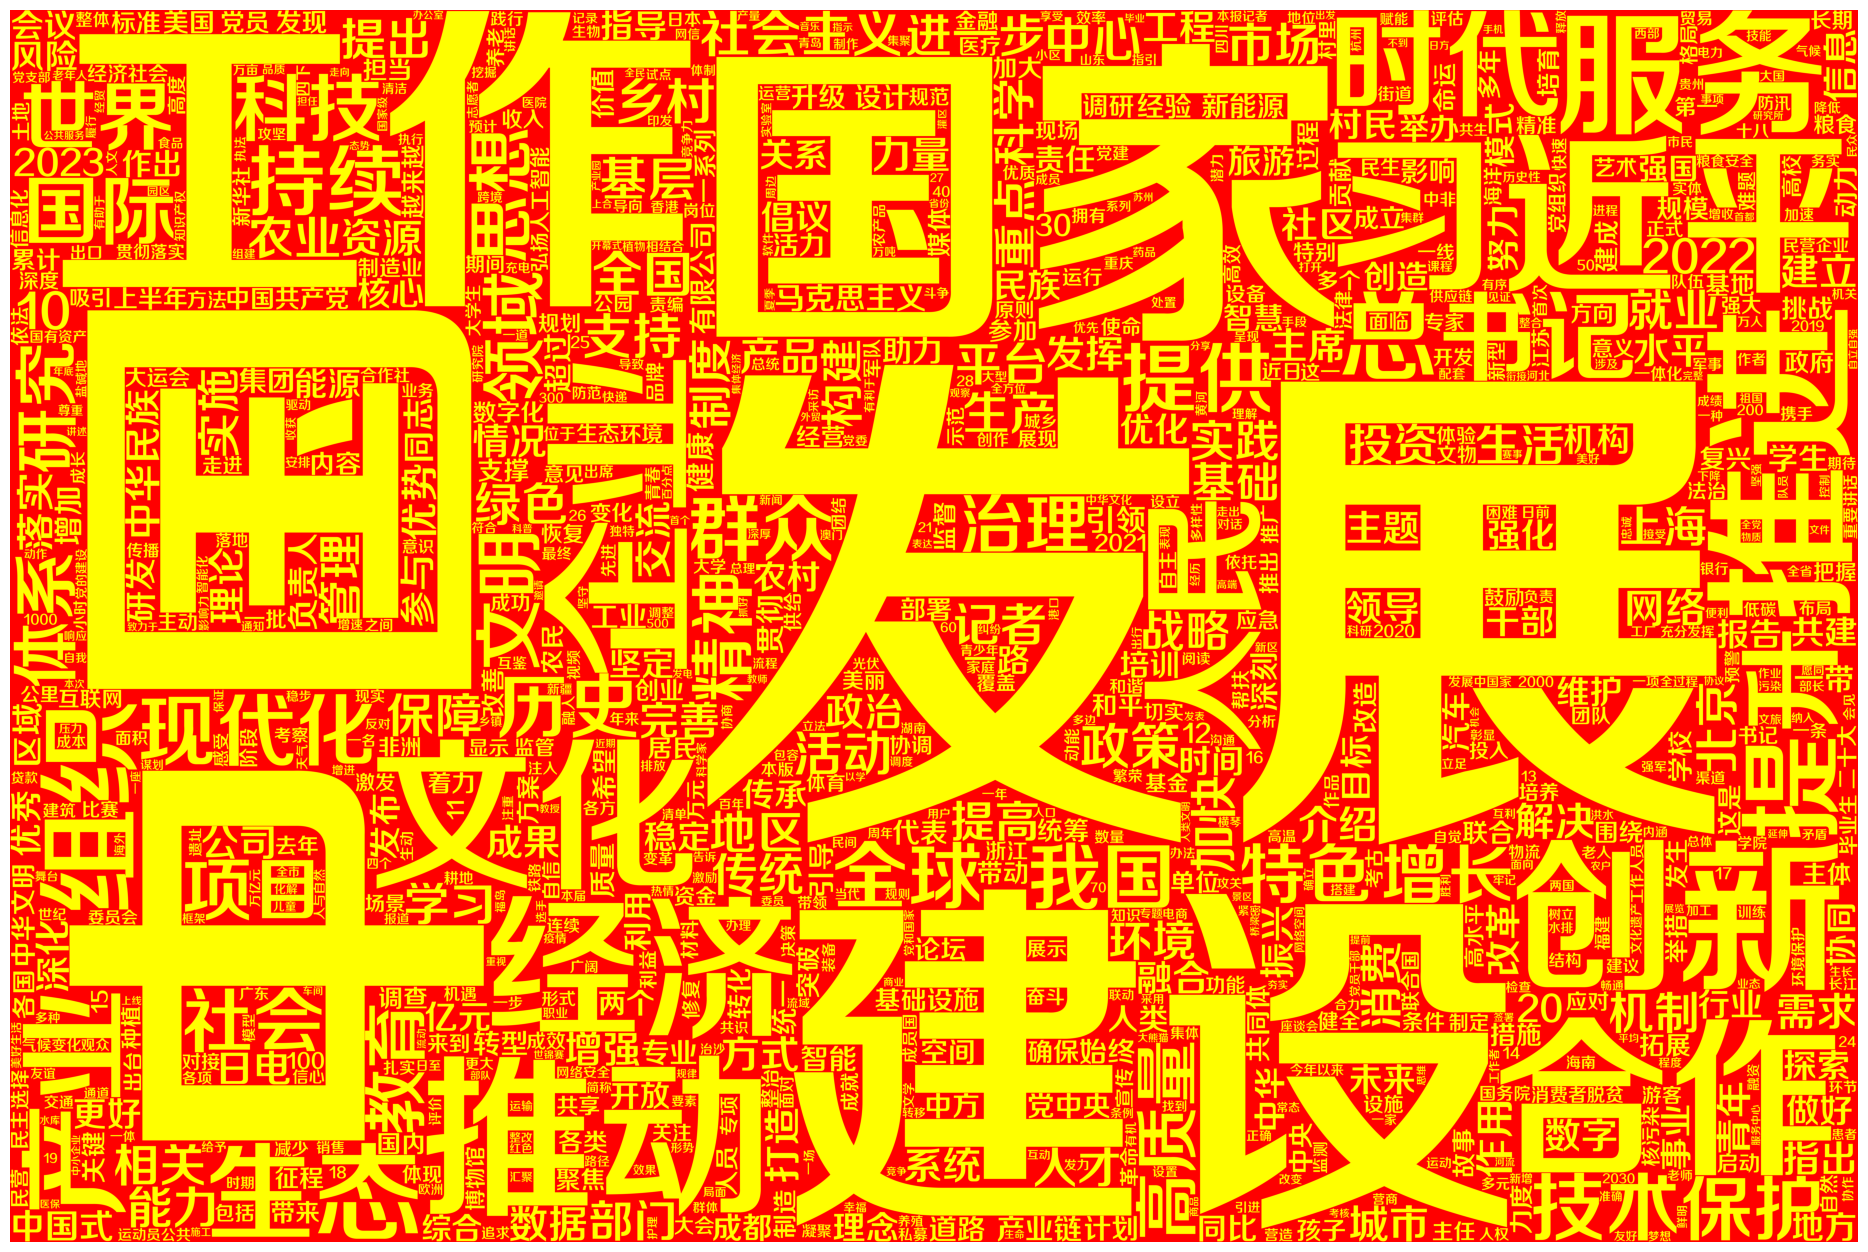

代码块执行时间：421.7967858314514 秒


In [18]:
print('2023年7月文章的词云图像')
draw_wordcloud(word_remove_stopword_count_202307)

2023年8月文章的词云图像
开始初始化WordCloud init
初始化完成! 开始生成WordCloud图片!预计400秒
生成图片完成! 开始保存图片!


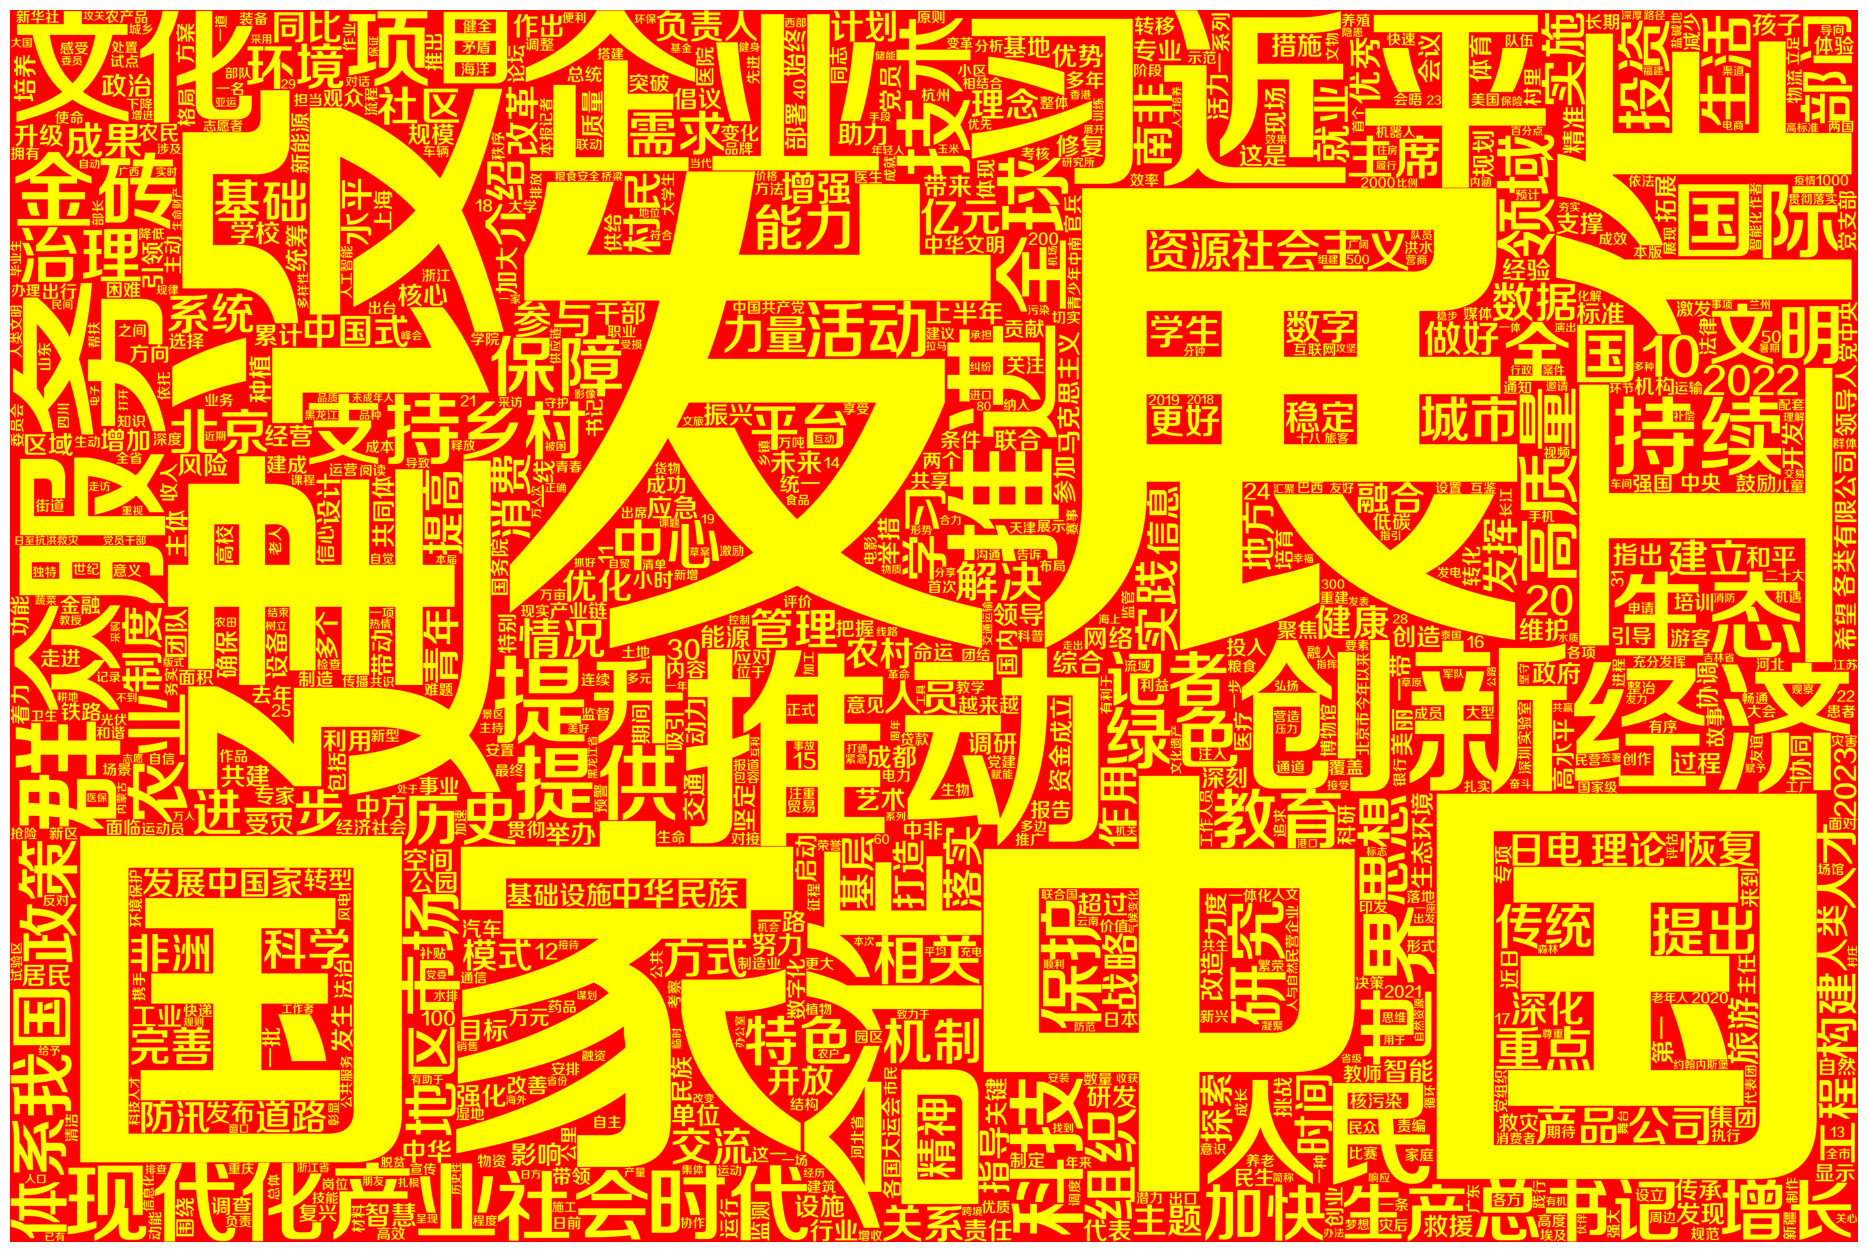

代码块执行时间：496.0074188709259 秒


In [19]:
print('2023年8月文章的词云图像')
draw_wordcloud(word_remove_stopword_count_202308)

2023年9月文章的词云图像
开始初始化WordCloud init
初始化完成! 开始生成WordCloud图片!预计400秒
生成图片完成! 开始保存图片!


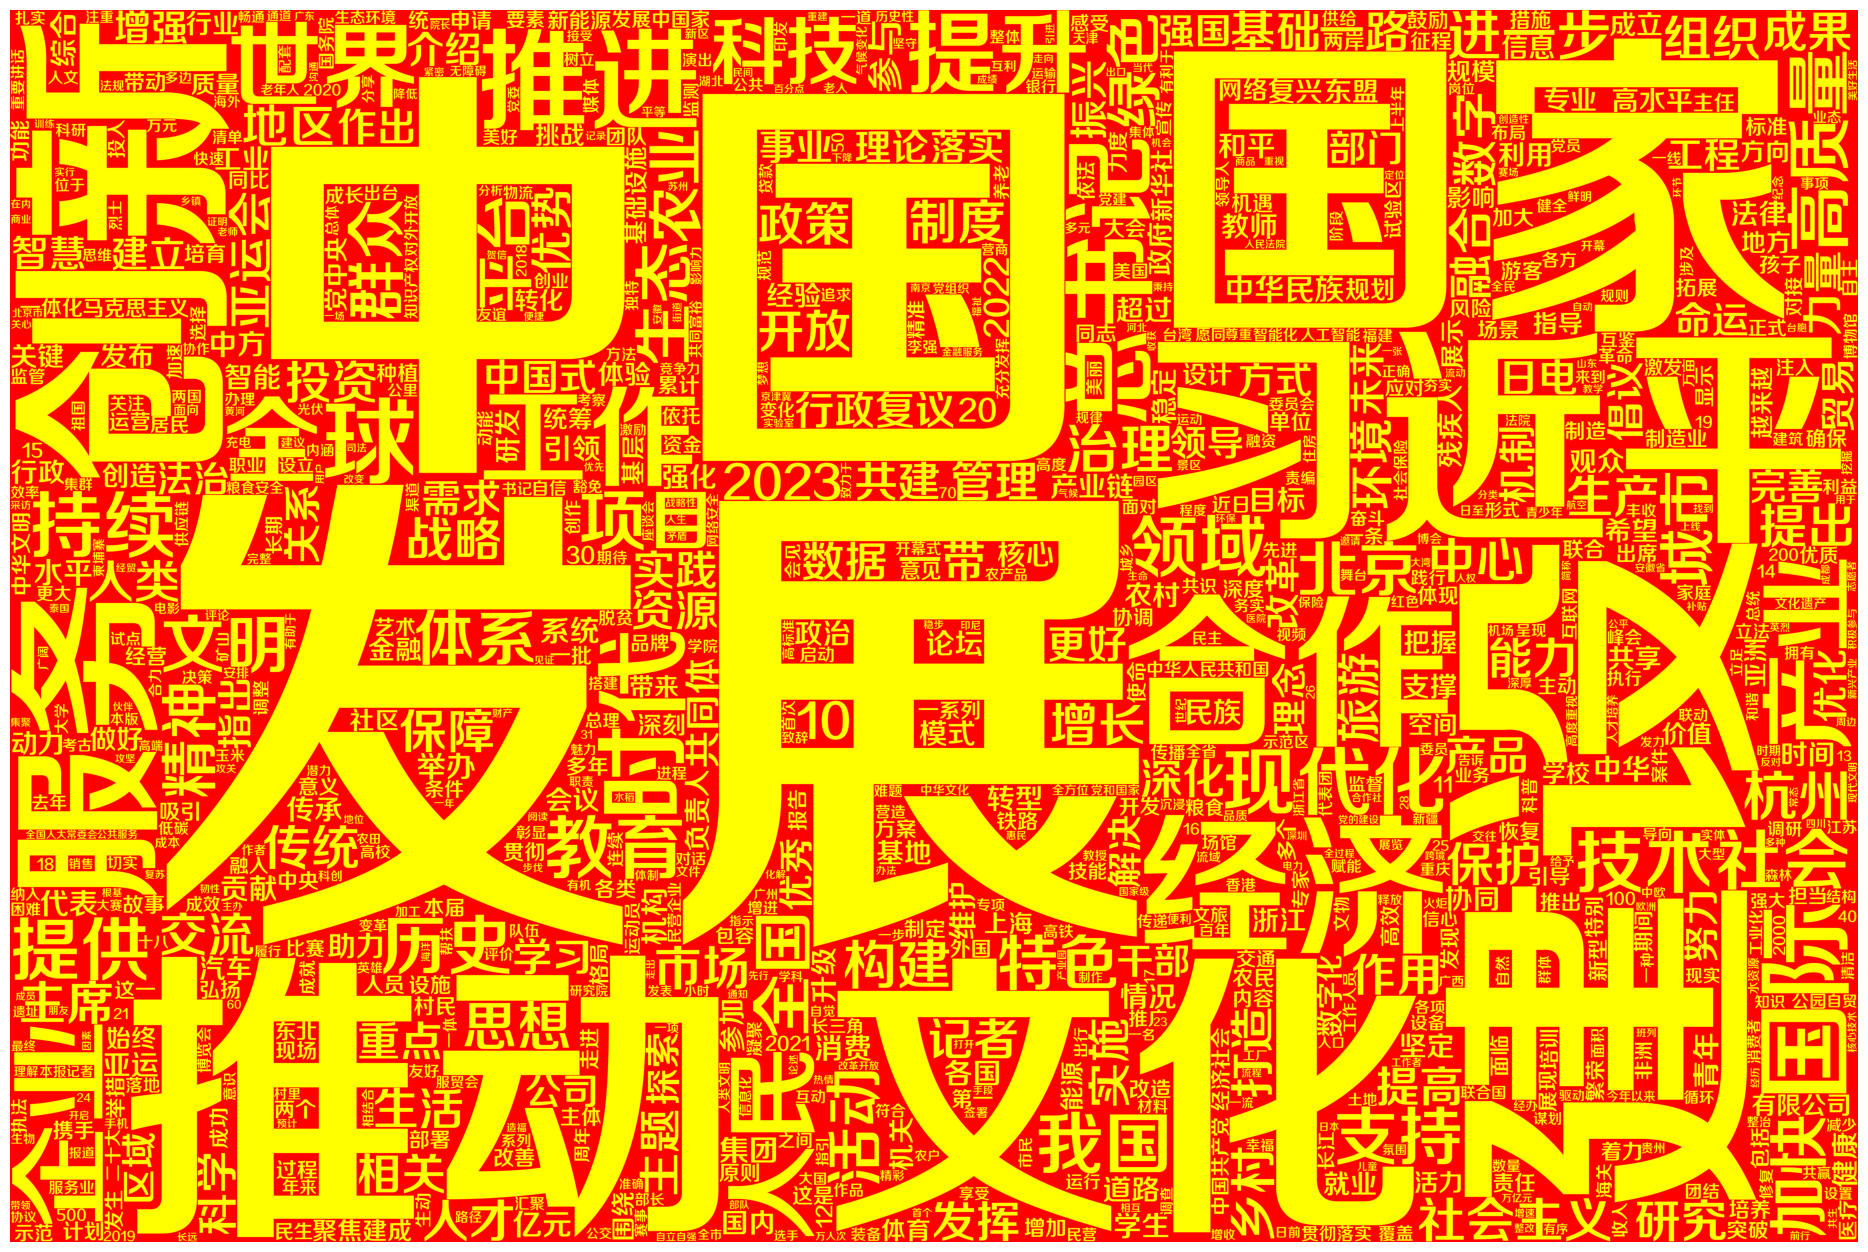

代码块执行时间：436.5646893978119 秒


In [20]:
print('2023年9月文章的词云图像')
draw_wordcloud(word_remove_stopword_count_202309)

2023年10月文章的词云图像
开始初始化WordCloud init
初始化完成! 开始生成WordCloud图片!预计400秒
生成图片完成! 开始保存图片!


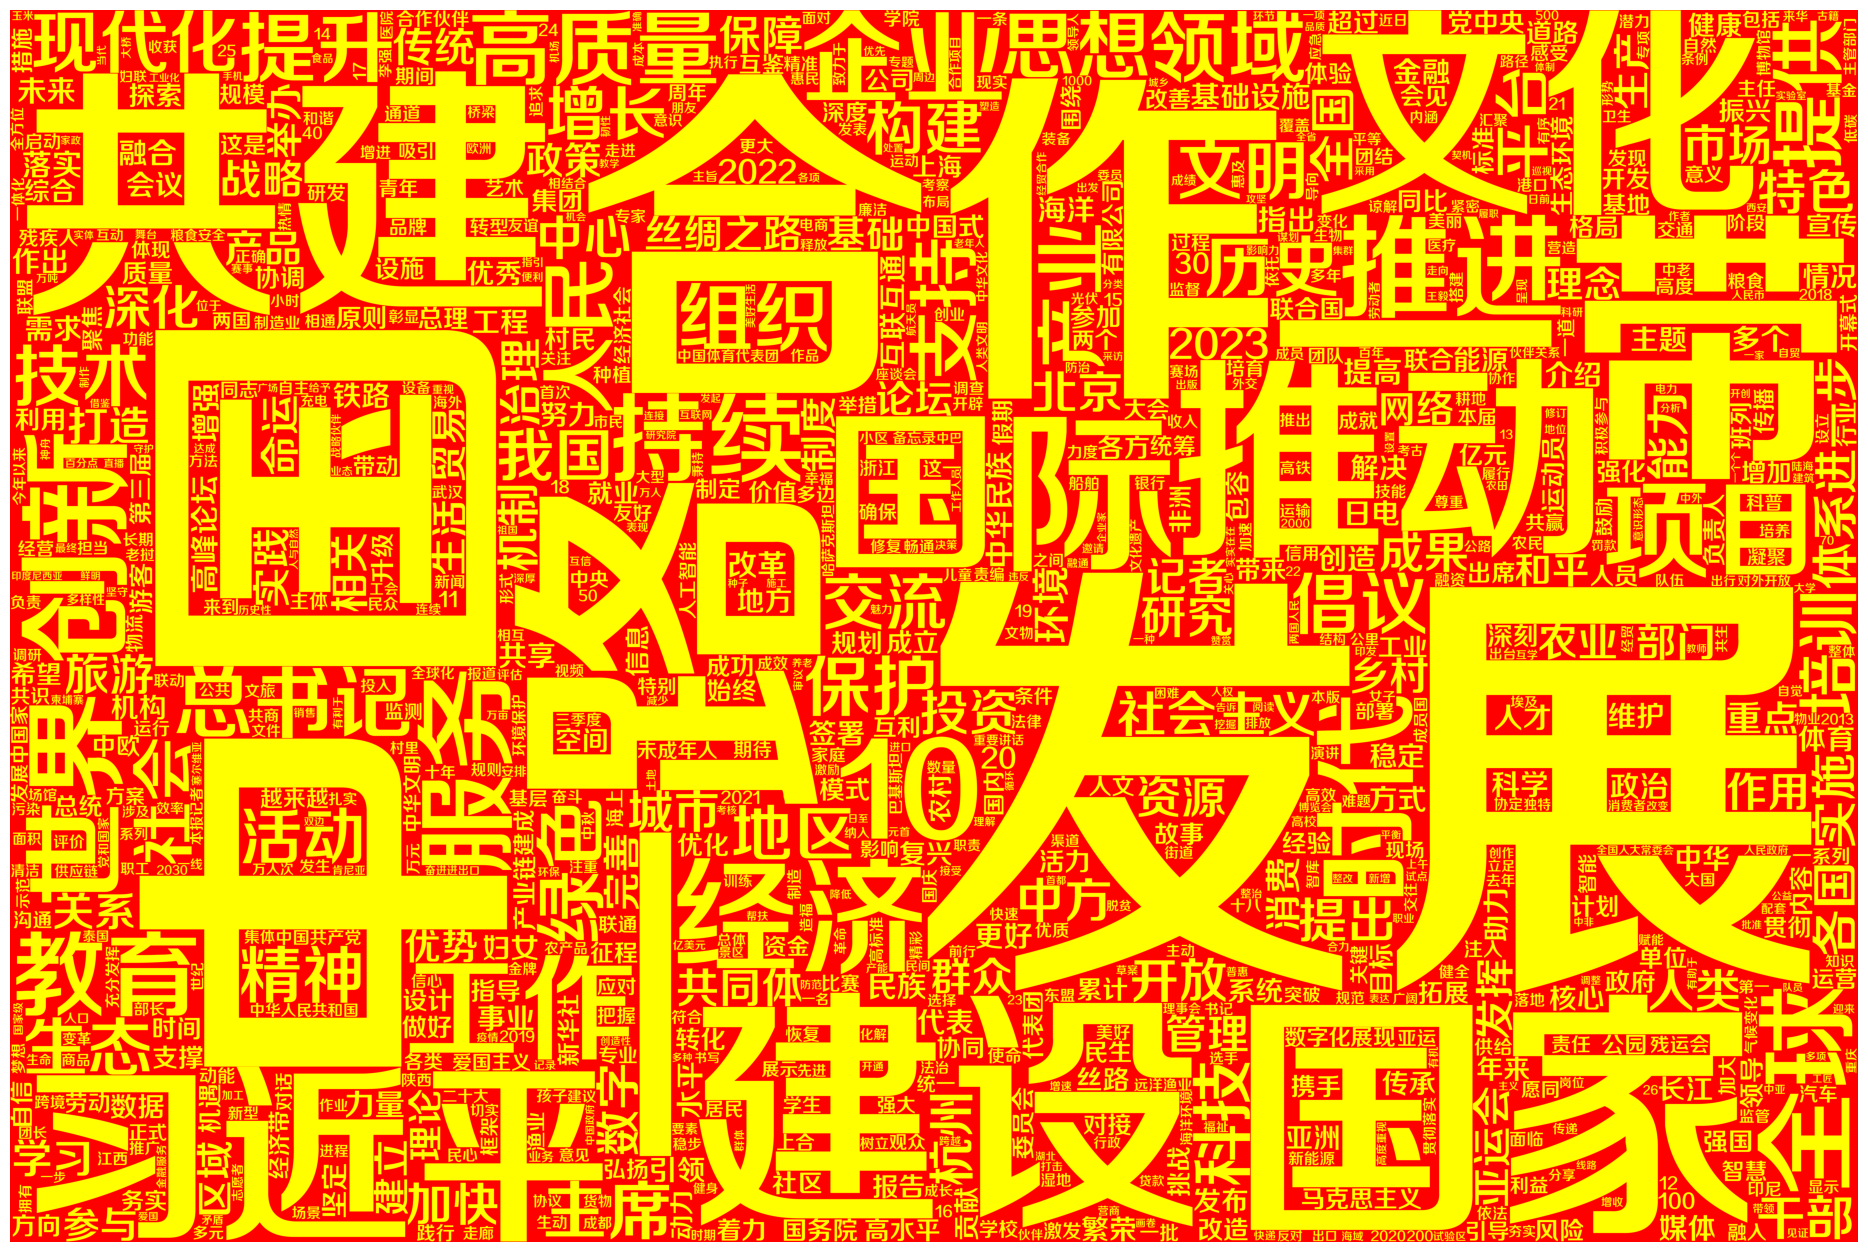

代码块执行时间：443.7627909183502 秒


In [21]:
print('2023年10月文章的词云图像')
draw_wordcloud(word_remove_stopword_count_202310)

2023年11月文章的词云图像
开始初始化WordCloud init
初始化完成! 开始生成WordCloud图片!预计400秒
生成图片完成! 开始保存图片!


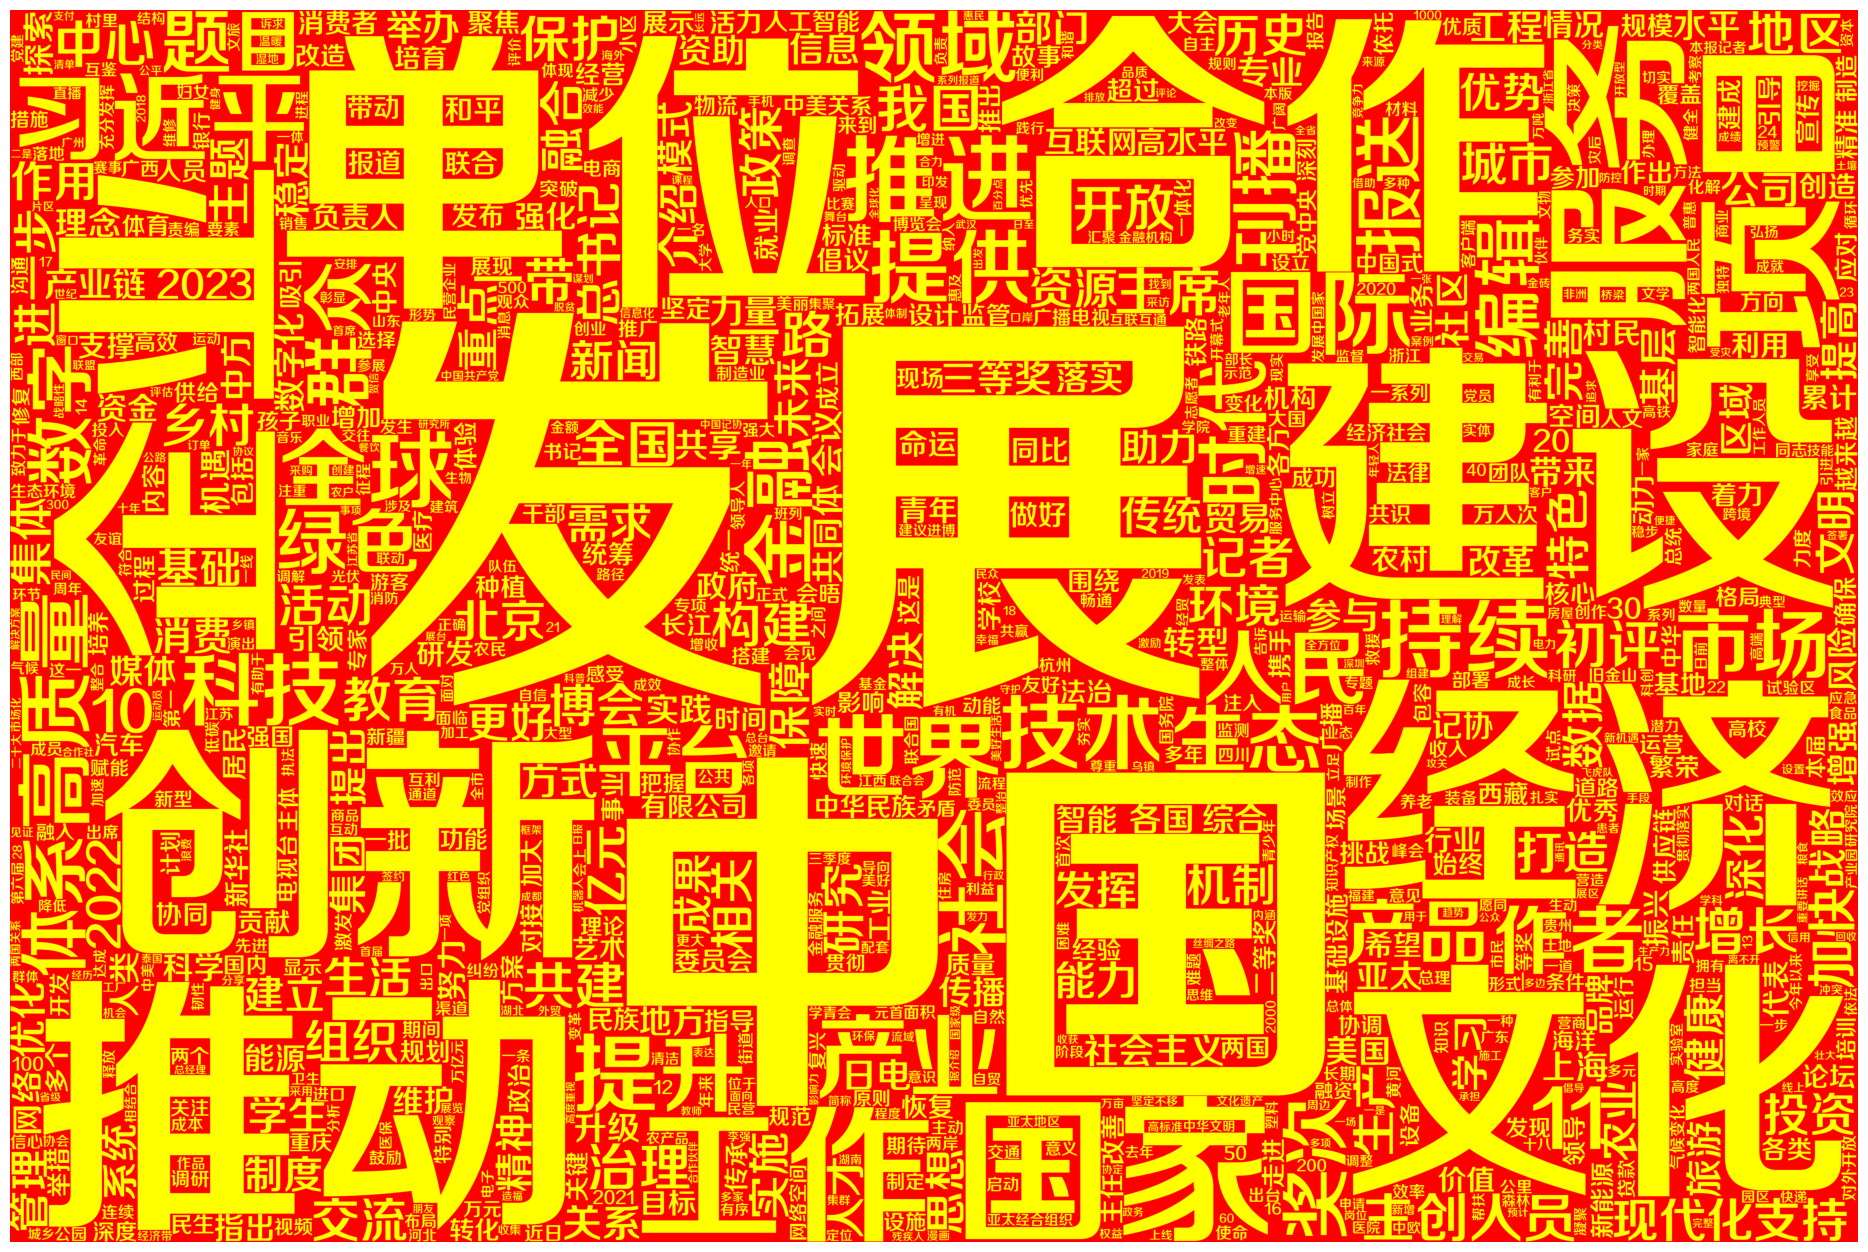

代码块执行时间：426.36785316467285 秒


In [22]:
print('2023年11月文章的词云图像')
draw_wordcloud(word_remove_stopword_count_202311)

### 以07月top15的关键字为基准，统计5个月的变化

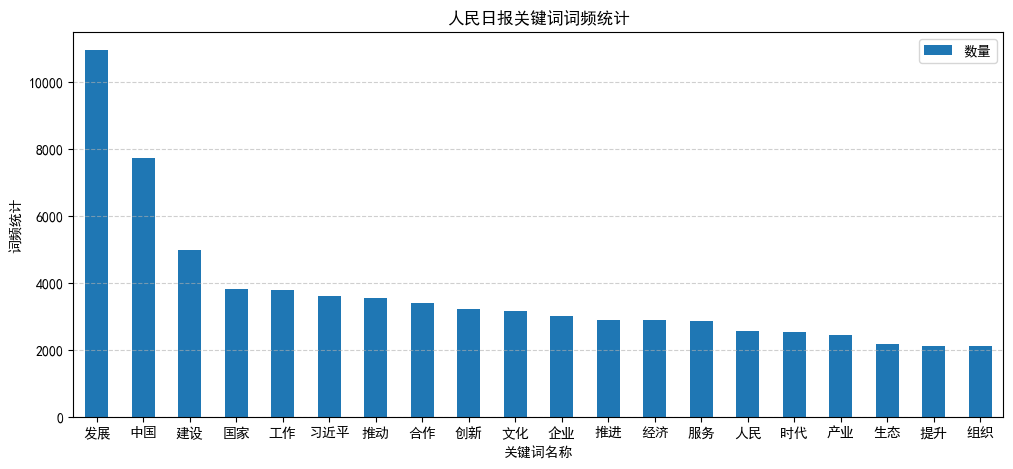

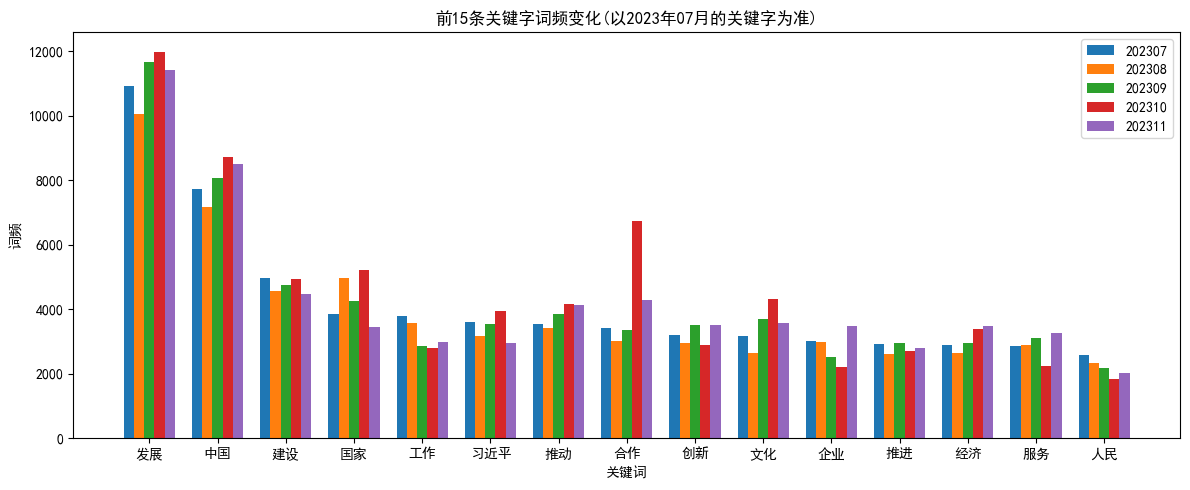

In [7]:
draw_word_frequency_distribution(word_remove_stopword_count_202307)
draw_word_frequency_changes(word_remove_stopword_count_202307, word_remove_stopword_count_202308, word_remove_stopword_count_202309, word_remove_stopword_count_202310, word_remove_stopword_count_202311, 1)

### 以08月top15的关键字为基准，统计5个月的变化

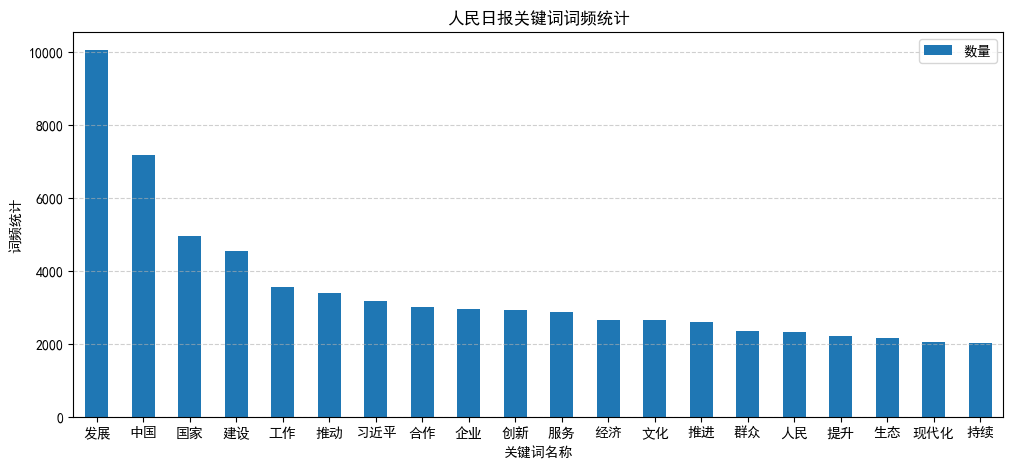

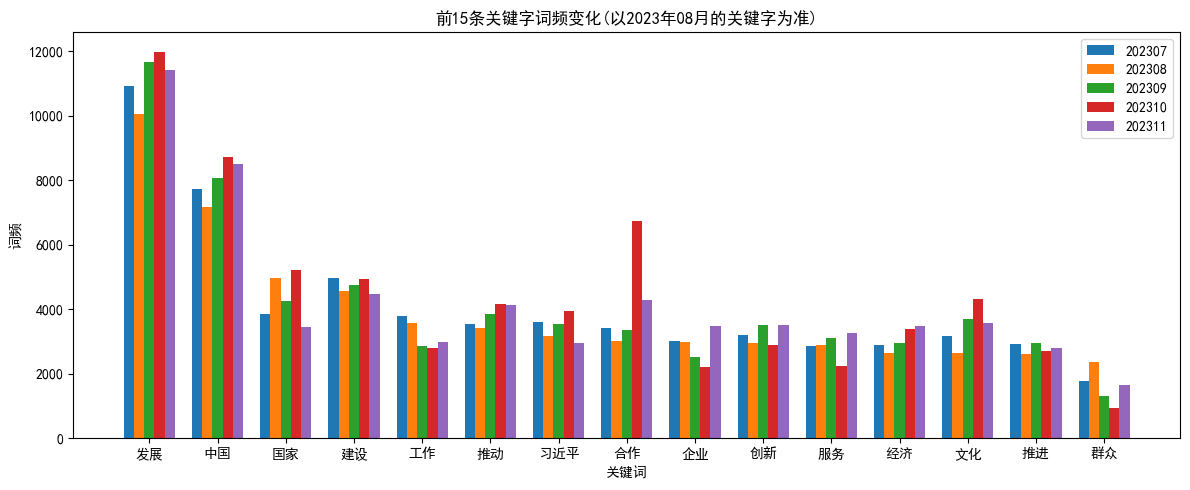

In [8]:
draw_word_frequency_distribution(word_remove_stopword_count_202308)
draw_word_frequency_changes(word_remove_stopword_count_202307, word_remove_stopword_count_202308, word_remove_stopword_count_202309, word_remove_stopword_count_202310, word_remove_stopword_count_202311, 2)

### 以09月top15的关键字为基准，统计5个月的变化

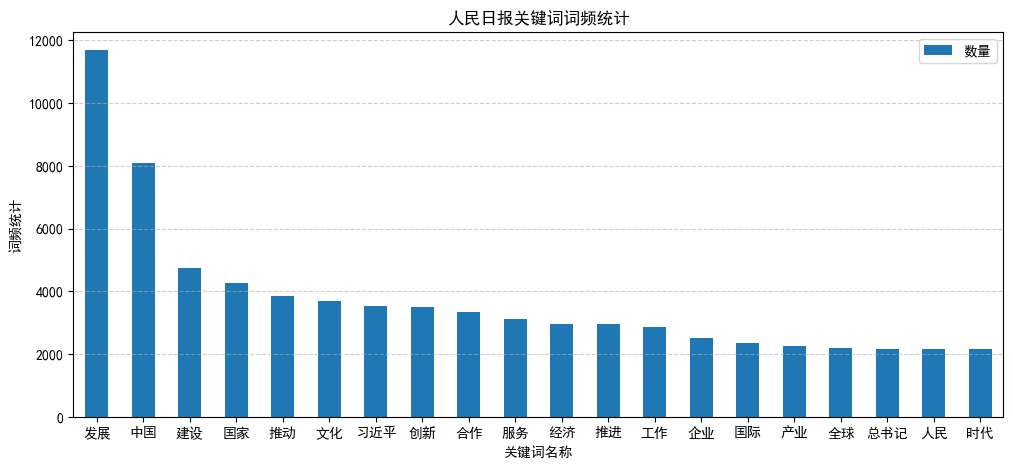

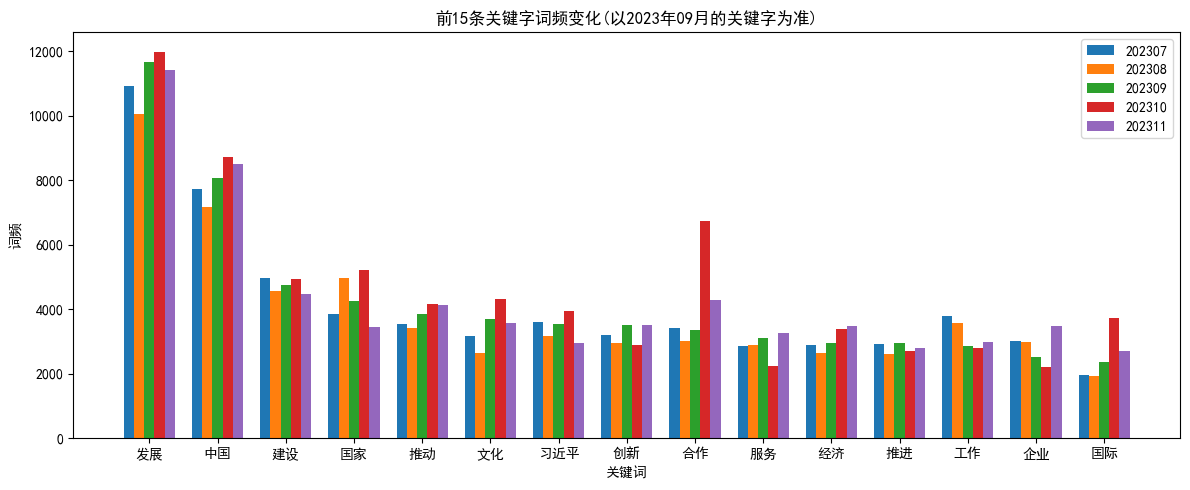

In [9]:
draw_word_frequency_distribution(word_remove_stopword_count_202309)
draw_word_frequency_changes(word_remove_stopword_count_202307, word_remove_stopword_count_202308, word_remove_stopword_count_202309, word_remove_stopword_count_202310, word_remove_stopword_count_202311, 3)

### 以10月top15的关键字为基准，统计5个月的变化

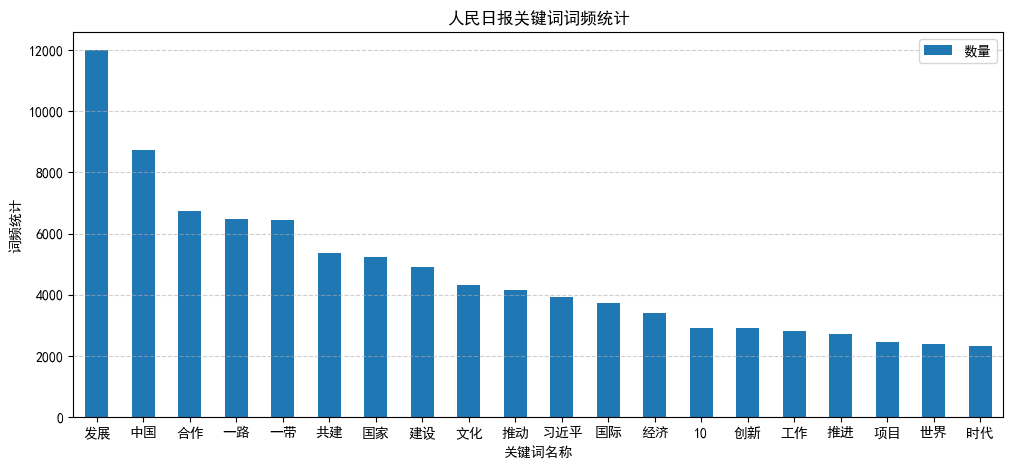

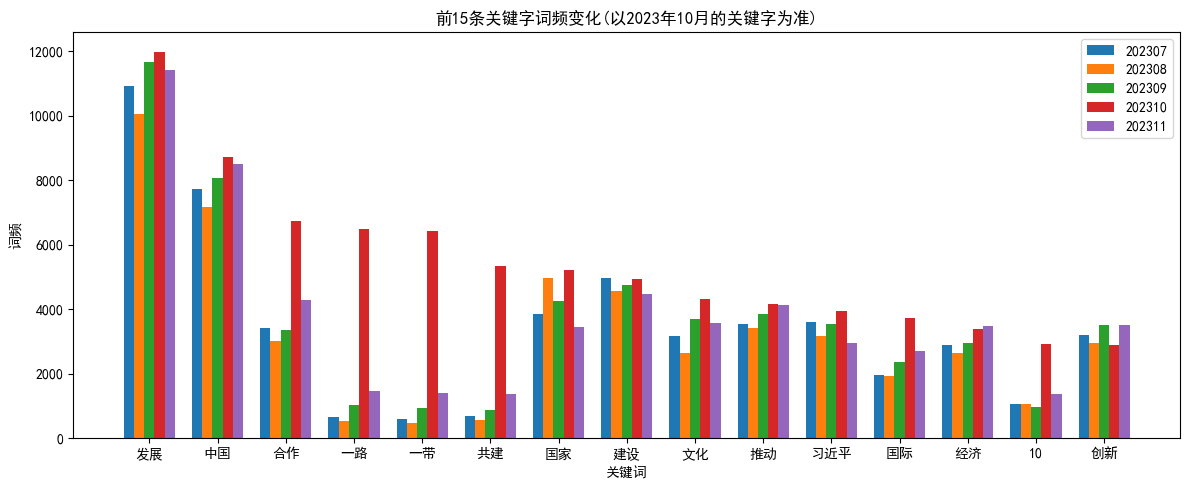

In [10]:
draw_word_frequency_distribution(word_remove_stopword_count_202310)
draw_word_frequency_changes(word_remove_stopword_count_202307, word_remove_stopword_count_202308, word_remove_stopword_count_202309, word_remove_stopword_count_202310, word_remove_stopword_count_202311, 4)

### 以11月top15的关键字为基准，统计5个月的变化

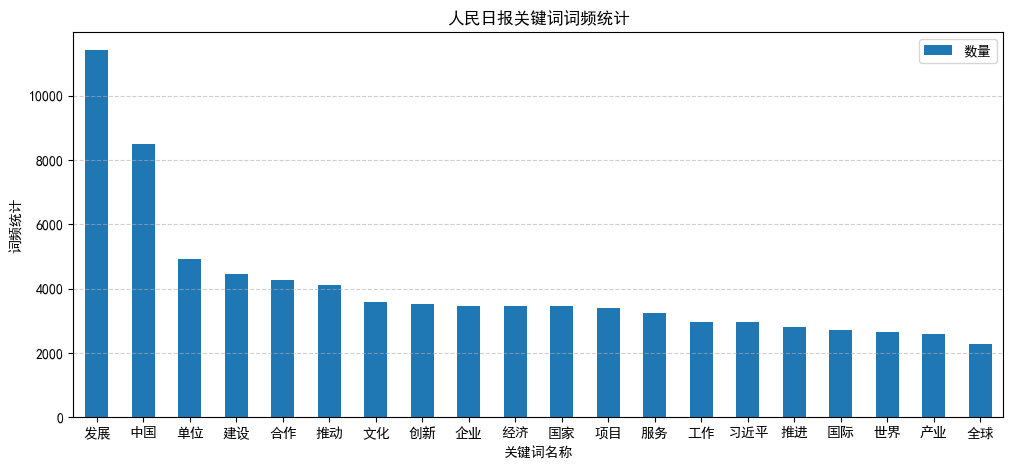

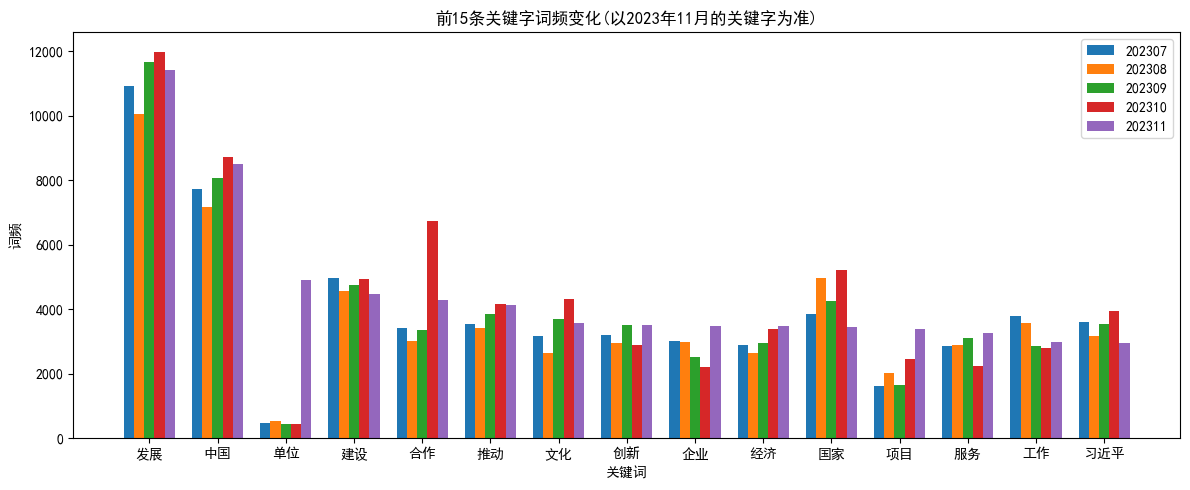

In [11]:
draw_word_frequency_distribution(word_remove_stopword_count_202311)
draw_word_frequency_changes(word_remove_stopword_count_202307, word_remove_stopword_count_202308, word_remove_stopword_count_202309, word_remove_stopword_count_202310, word_remove_stopword_count_202311, 5)

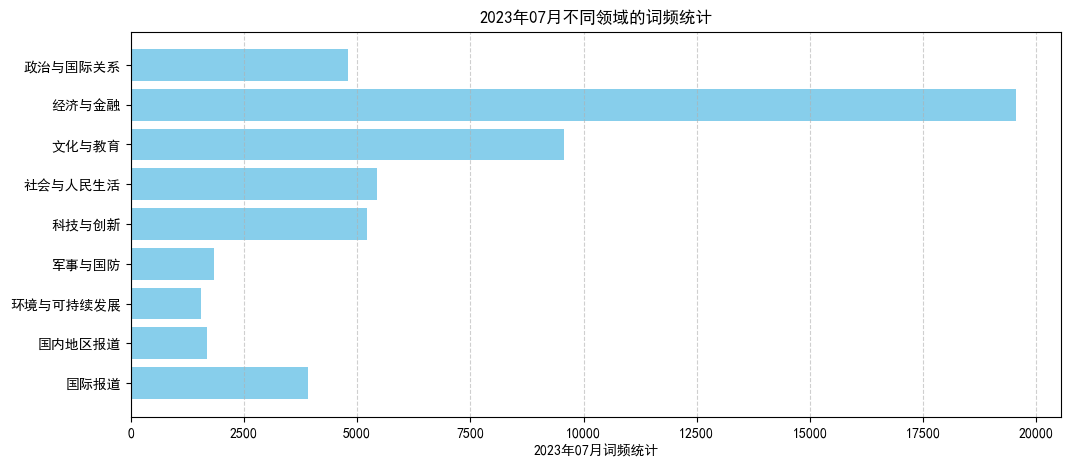

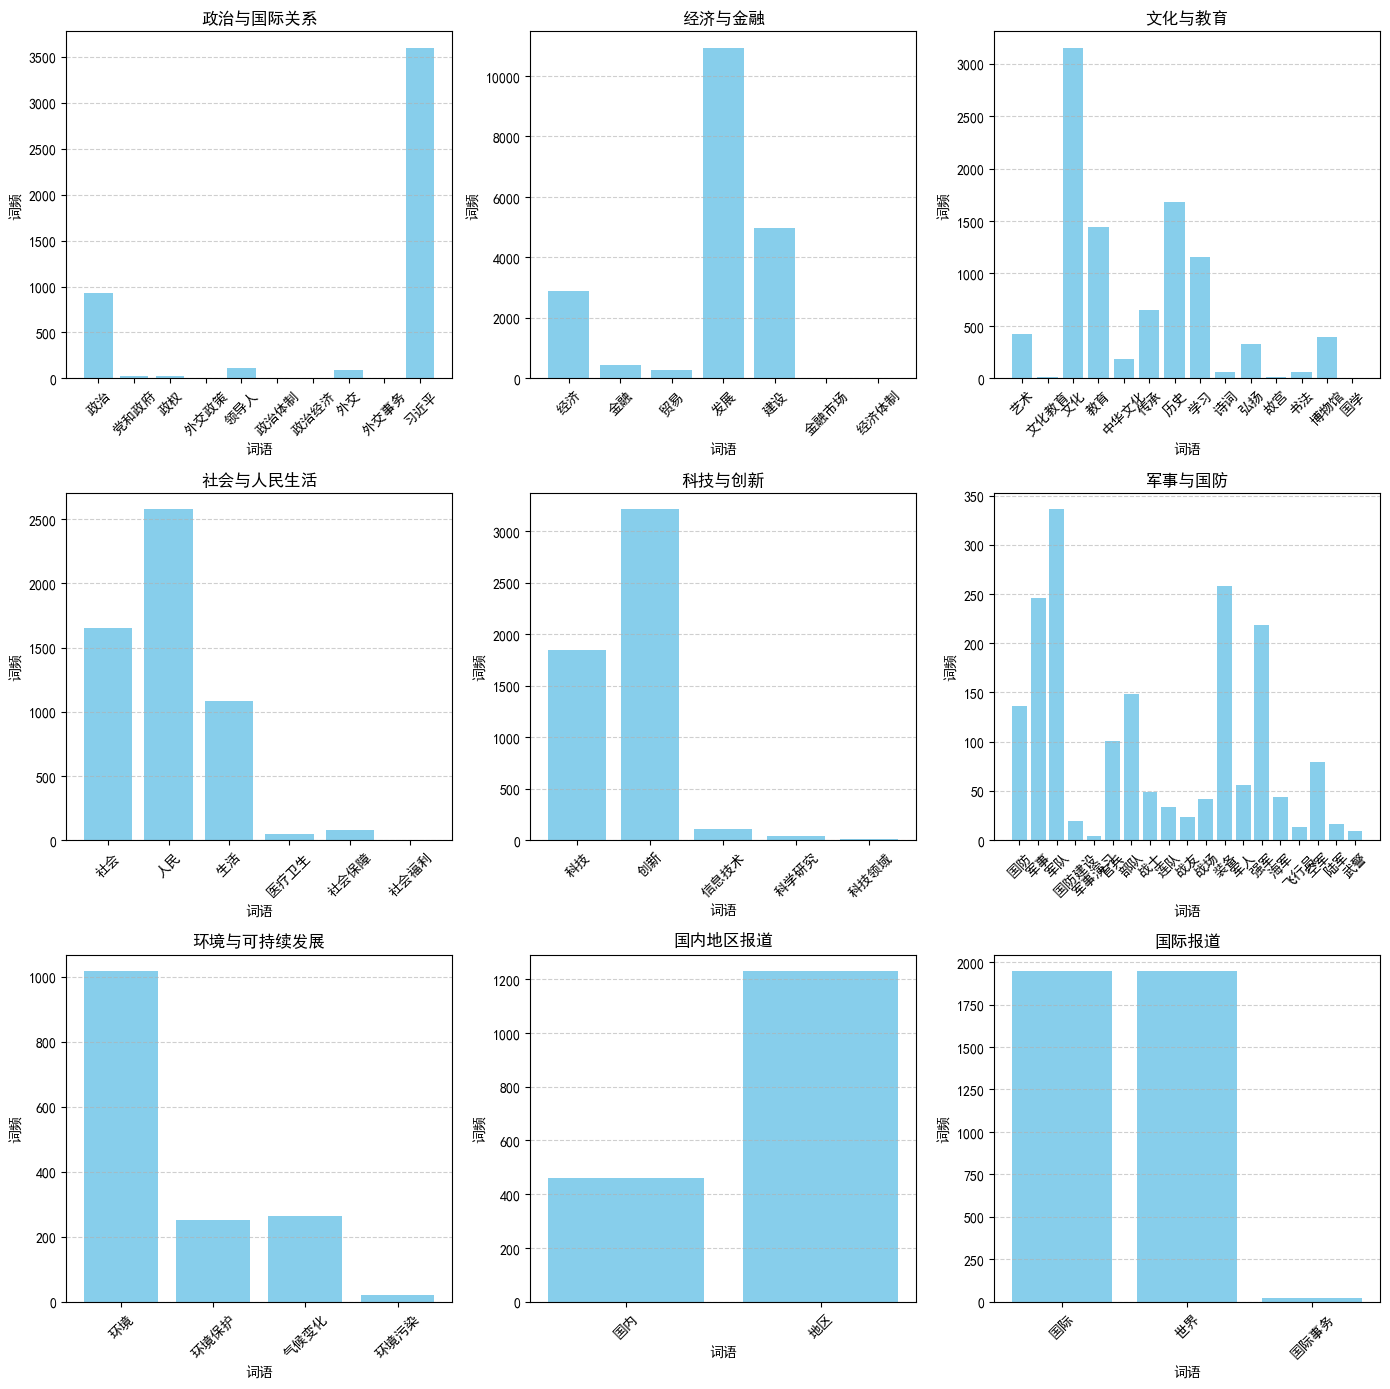

In [12]:
scategory_word_counts_sum_202307 = get_word_frequency_statistics_for_each_field(word_remove_stopword_count_202307, '202307')

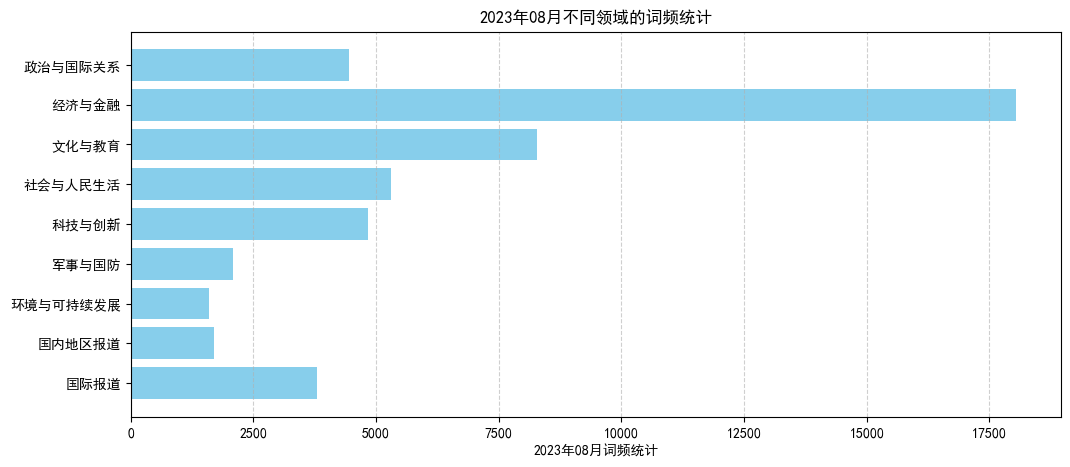

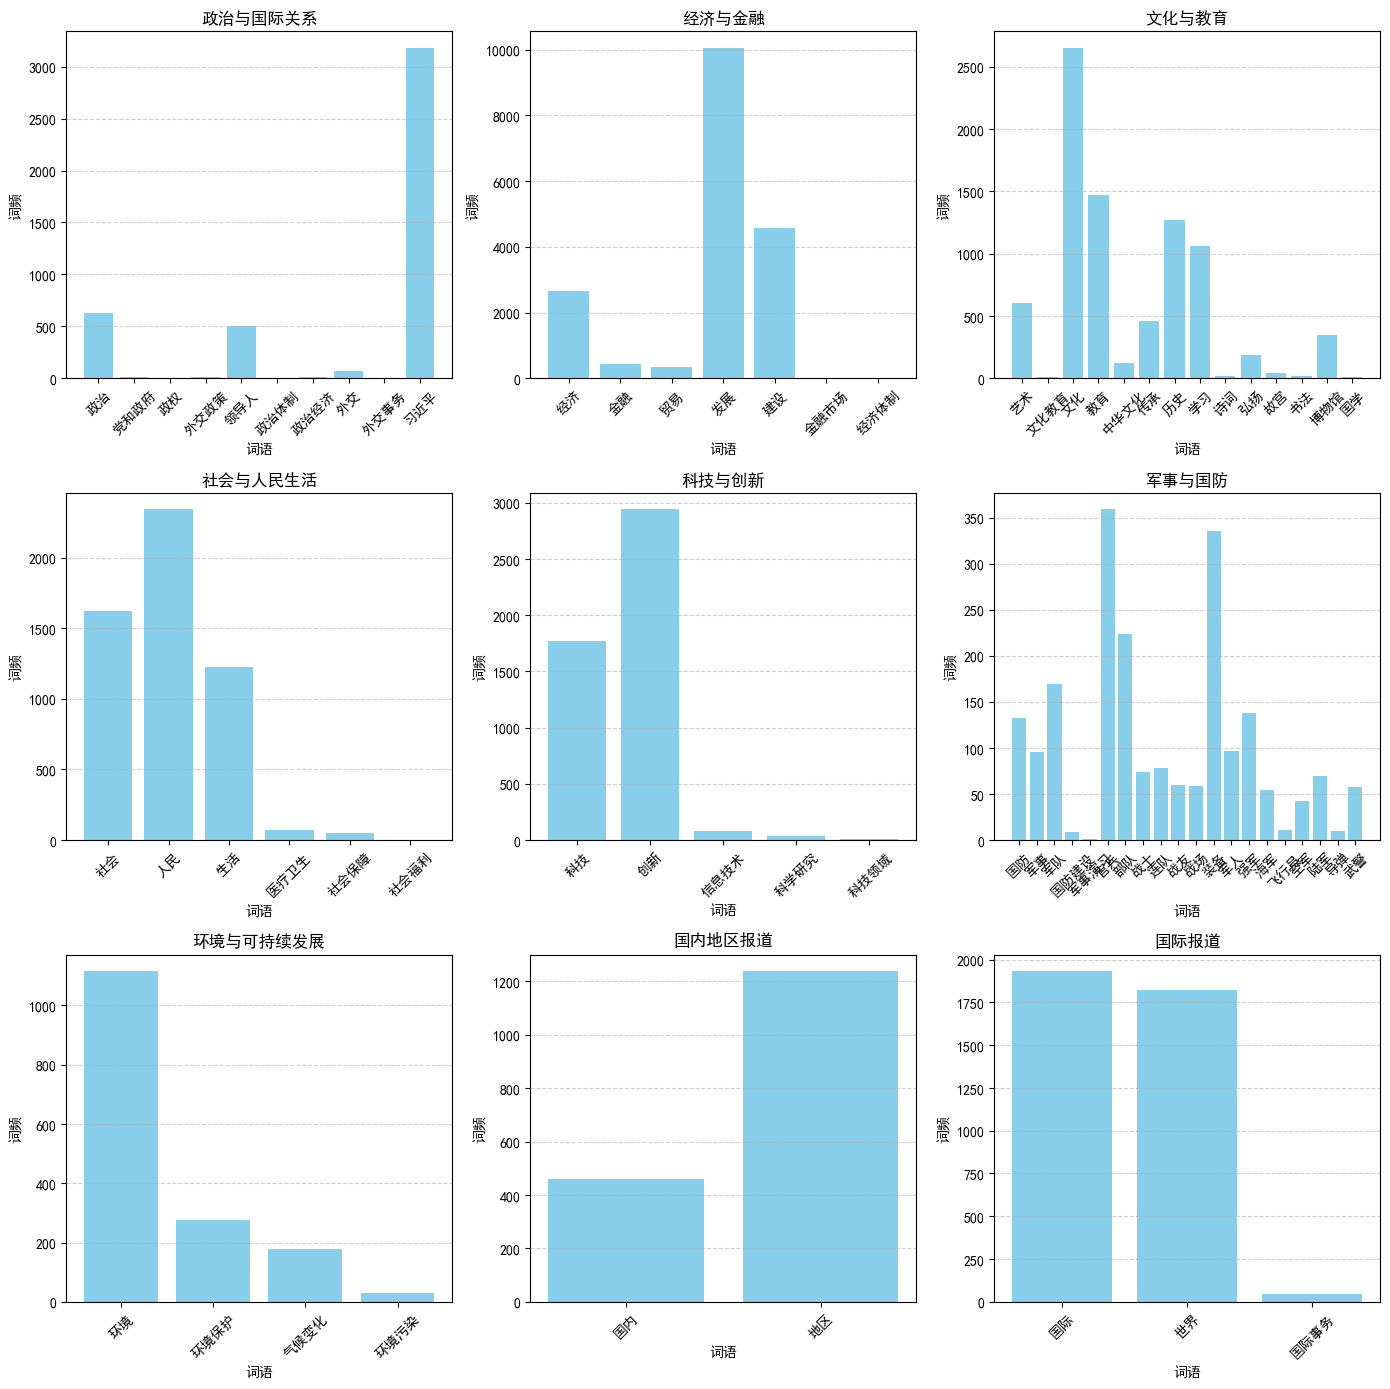

In [13]:
scategory_word_counts_sum_202308 = get_word_frequency_statistics_for_each_field(word_remove_stopword_count_202308, '202308')

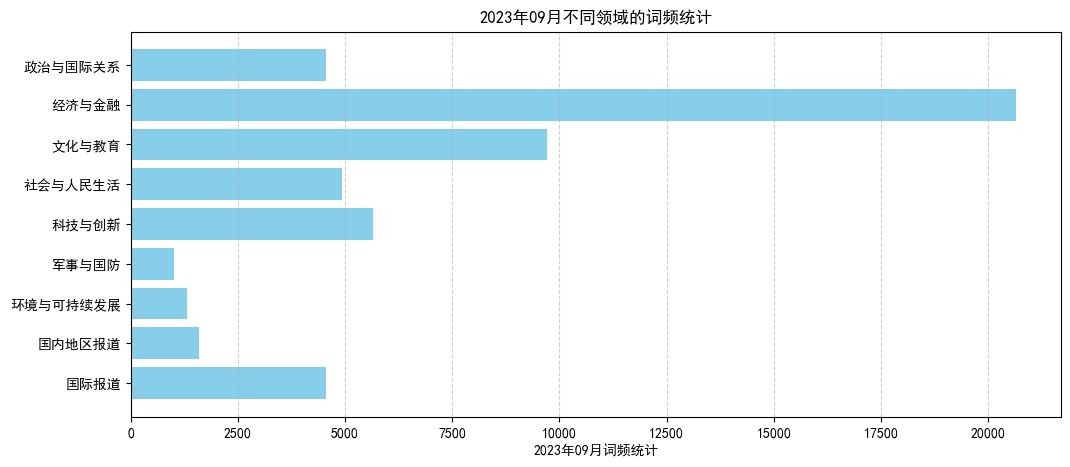

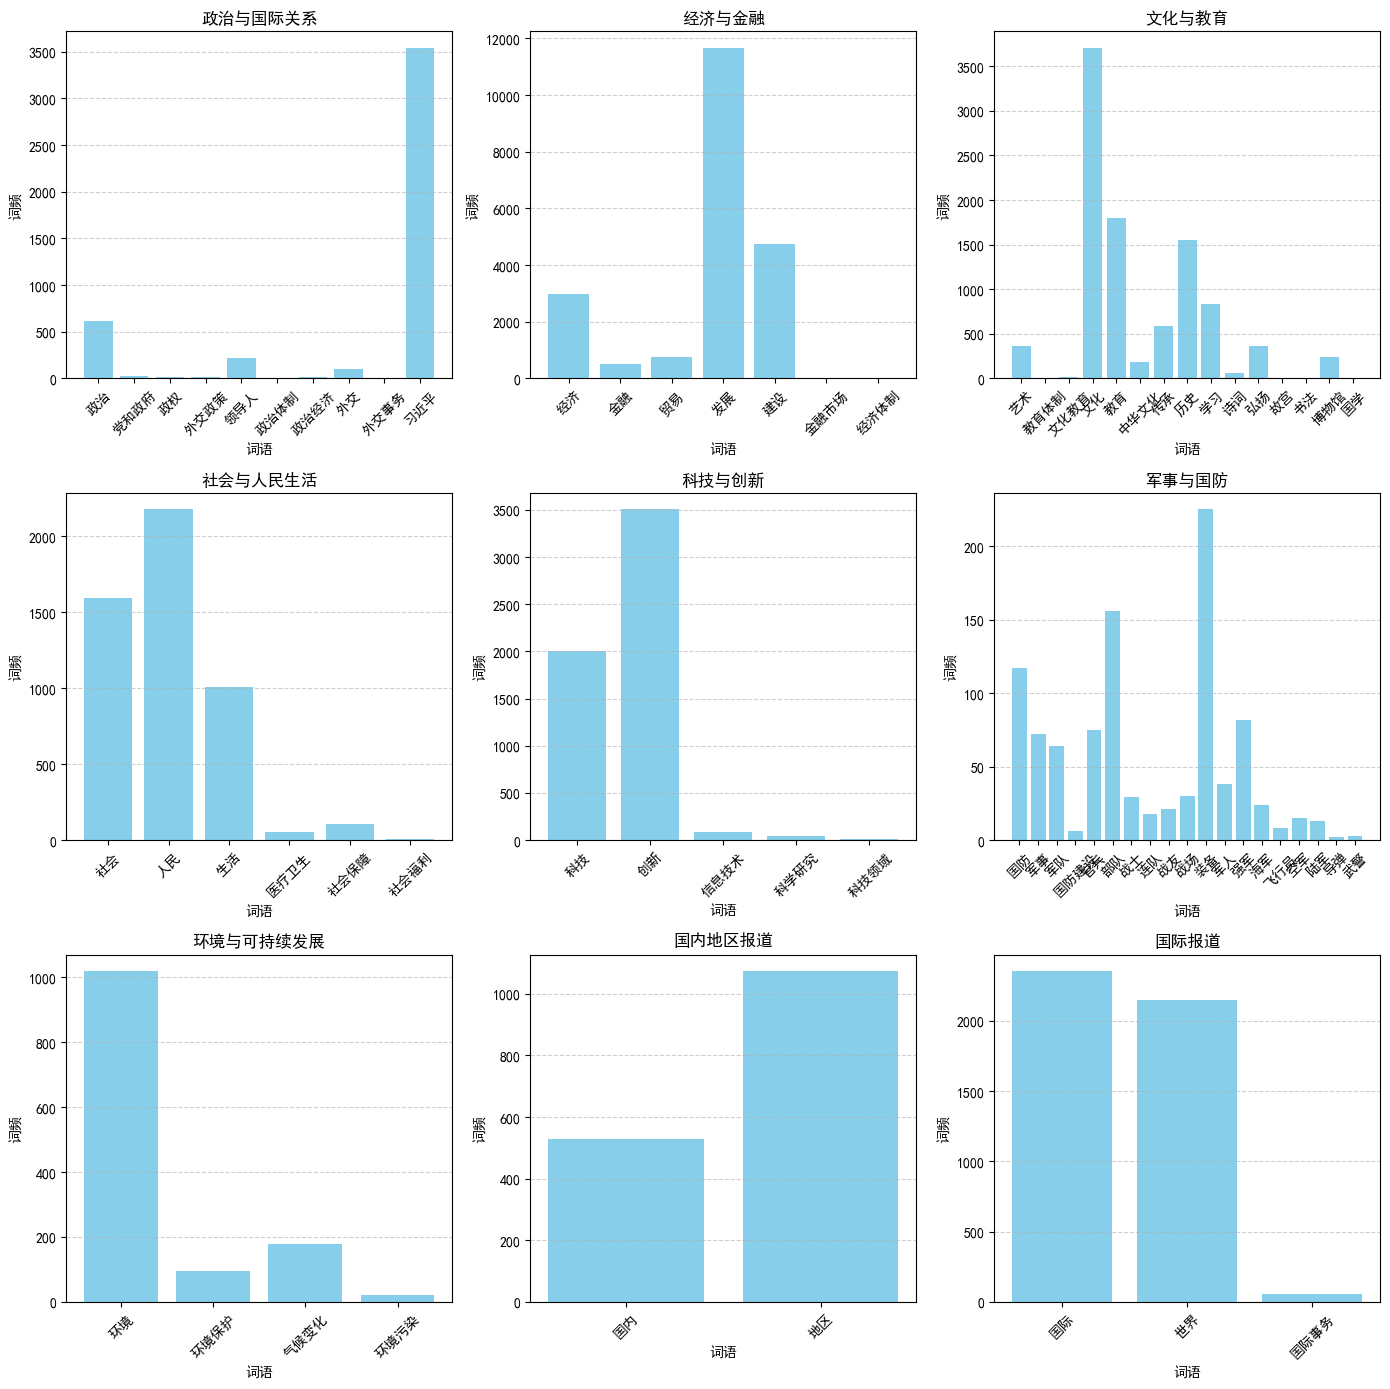

In [14]:
scategory_word_counts_sum_202309 = get_word_frequency_statistics_for_each_field(word_remove_stopword_count_202309, '202309')

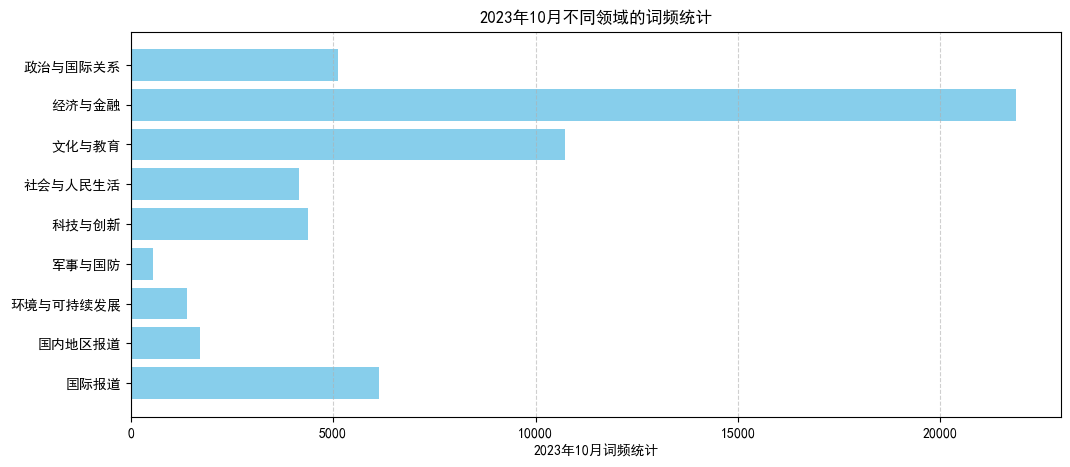

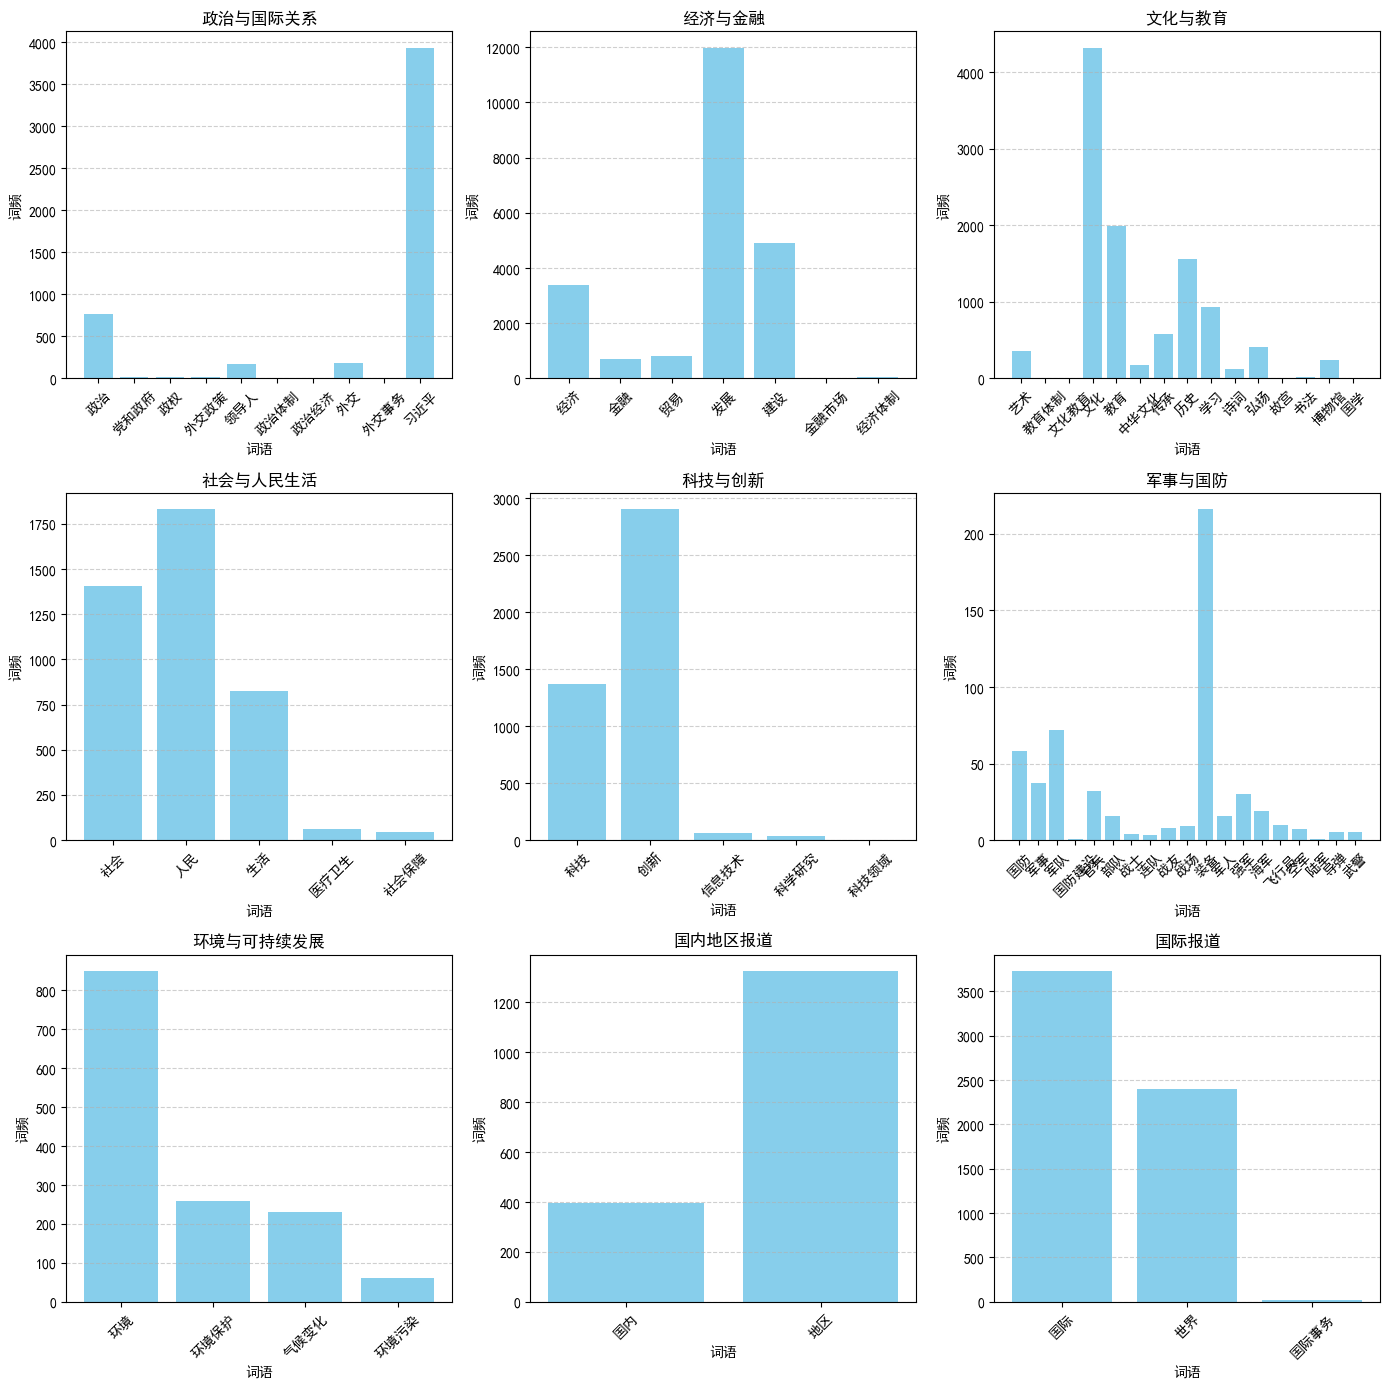

In [15]:
scategory_word_counts_sum_202310 = get_word_frequency_statistics_for_each_field(word_remove_stopword_count_202310, '202310')

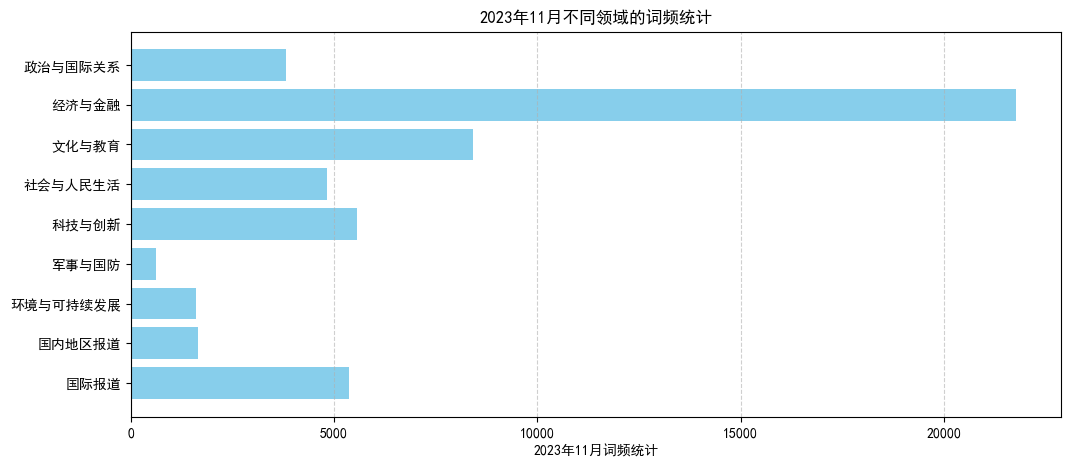

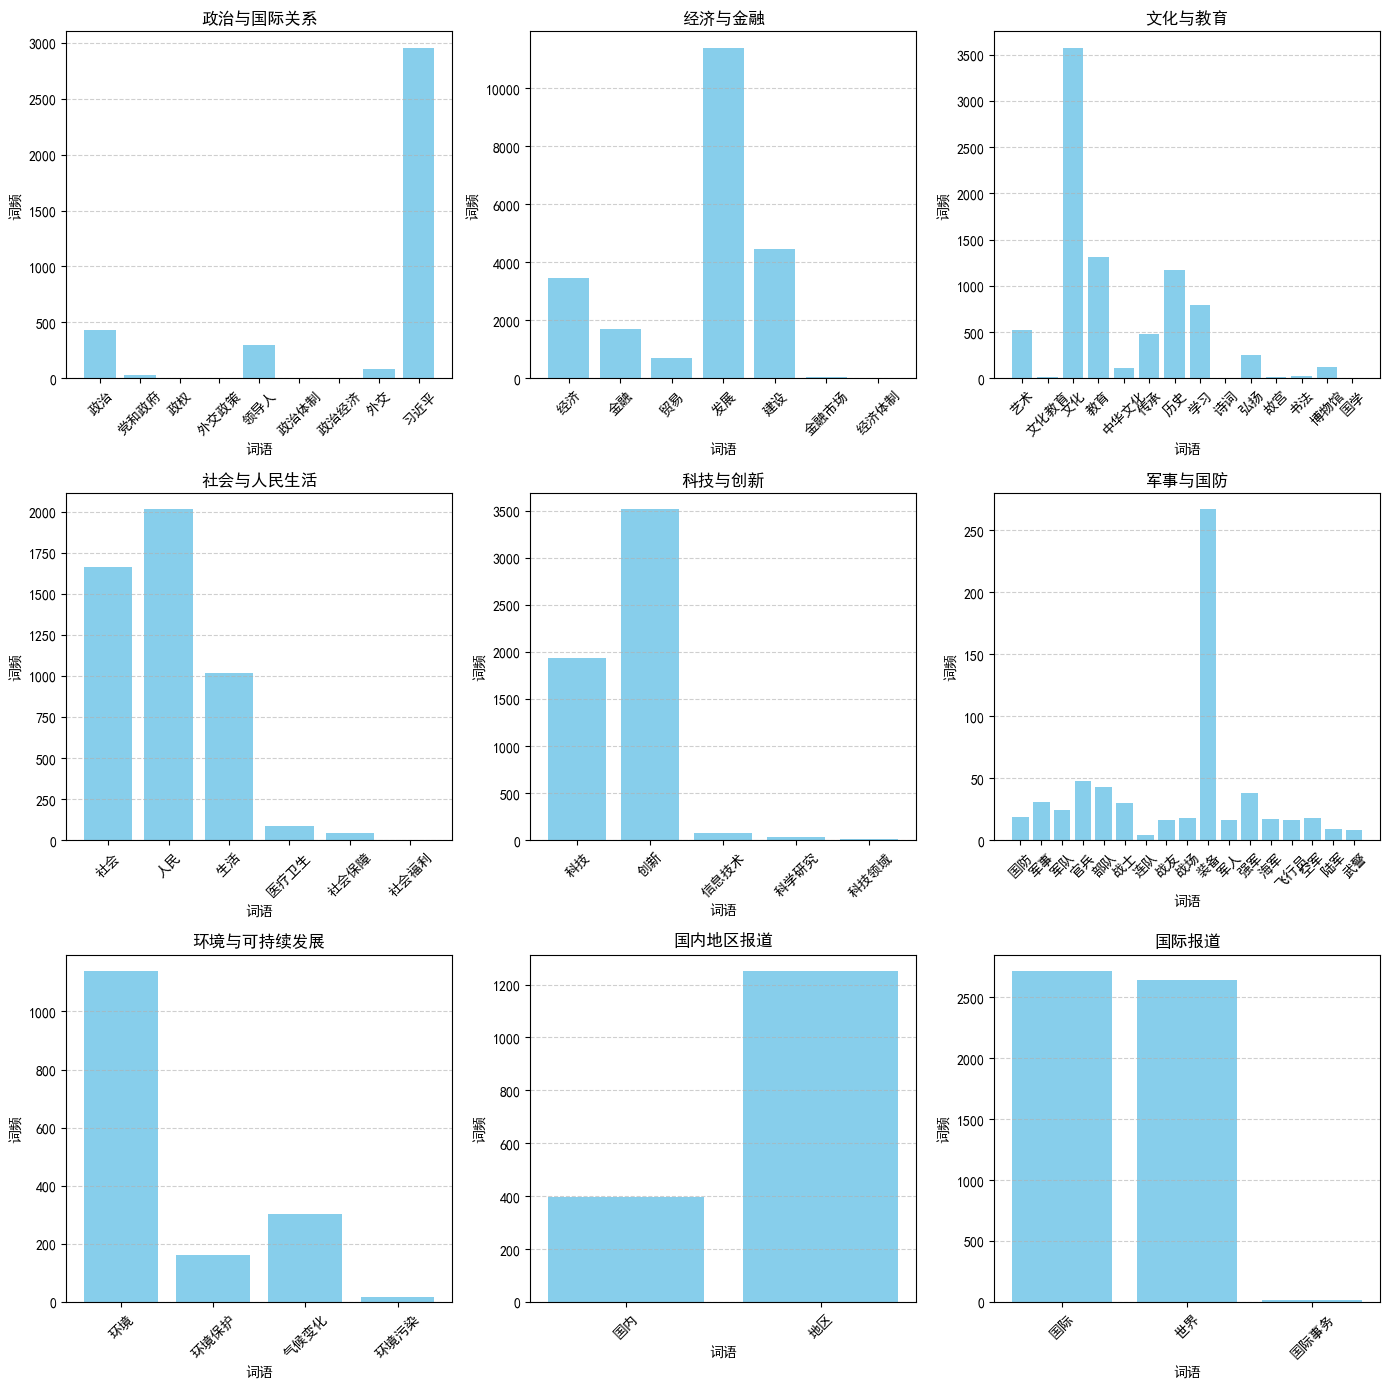

In [16]:
scategory_word_counts_sum_202311 = get_word_frequency_statistics_for_each_field(word_remove_stopword_count_202311, '202311')

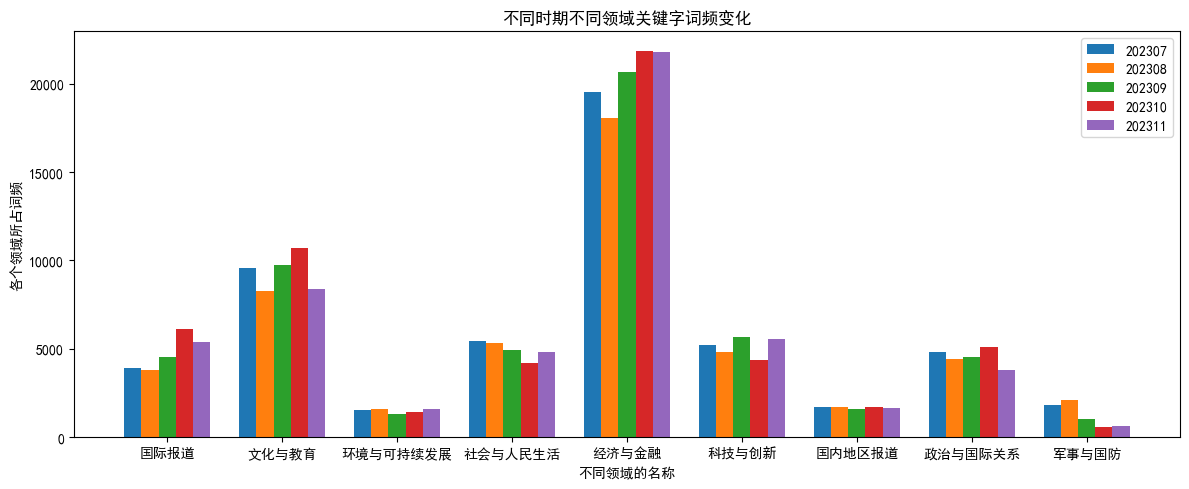

In [17]:
get_word_frequency_statistics_for_each_field_changes(scategory_word_counts_sum_202307,scategory_word_counts_sum_202308,scategory_word_counts_sum_202309,scategory_word_counts_sum_202310, scategory_word_counts_sum_202311)

## 一般显示方式

In [20]:

province = ['北京','天津','河北','山西','内蒙古','辽宁','吉林','黑龙江','上海','江苏','浙江','安徽','福建','江西','山东','河南','湖北','湖南','广东','广西','海南','重庆','四川','贵州','云南','西藏','陕西','甘肃','青海','宁夏','新疆']
province_coordinates = {
    '北京': [39.9042, 116.4074],
    '天津': [39.0842, 117.2008],
    '河北': [38.0428, 114.5149],
    '山西': [37.5267, 112.2922],
    '内蒙古': [40.8174, 111.7656],
    '辽宁': [41.2956, 122.6085],
    '吉林': [43.8378, 126.5494],
    '黑龙江': [45.8038, 126.5350],
    '上海': [31.2304, 121.4737],
    '江苏': [32.0603, 118.7969],
    '浙江': [30.26, 120.19],
    '安徽': [31.8257, 117.2264],
    '福建': [26.1008, 119.2951],
    '江西': [28.6742, 115.9101],
    '山东': [36.3427, 118.1498],
    '河南': [34.7466, 113.6254],
    '湖北': [30.5928, 114.3055],
    '湖南': [28.1124, 112.9838],
    '广东': [23.3790, 113.7633],
    '广西': [22.8155, 108.3275],
    '海南': [20.0171, 110.3492],
    '重庆': [29.4316, 106.9123],
    '四川': [30.5728, 104.0668],
    '贵州': [26.8154, 106.8748],
    '云南': [25.0458, 102.7103],
    '西藏': [29.6469, 91.1173],
    '陕西': [34.3416, 108.9398],
    '甘肃': [36.0611, 103.8343],
    '青海': [36.0611, 96.0983],
    '宁夏': [38.5026, 106.2065],
    '新疆': [43.7930, 87.6271]
    # 可根据需要继续添加其他省份的经纬度信息
}

import folium

data_1 = {item: word_remove_stopword_count_202307[item] for item in province if item in word_remove_stopword_count_202307.keys()}
data_2 = {item: word_remove_stopword_count_202308[item] for item in province if item in word_remove_stopword_count_202308.keys()}
data_3 = {item: word_remove_stopword_count_202309[item] for item in province if item in word_remove_stopword_count_202309.keys()}
data_4 = {item: word_remove_stopword_count_202310[item] for item in province if item in word_remove_stopword_count_202310.keys()}
data_5 = {item: word_remove_stopword_count_202311[item] for item in province if item in word_remove_stopword_count_202311.keys()}

# 创建地图对象
m = folium.Map(location=[35.8617, 104.1954], zoom_start=4)

# 根据不同月份的数据，在地图上添加标记，并使用不同颜色表示
def add_markers(map_obj, data, color, month):
    for province, value in data.items():
        folium.CircleMarker(
            location=province_coordinates[province],  # 假设 province_coordinates 存储了省份经纬度信息
            radius=value * 0.05,  # 根据值设置标记的半径大小
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            tooltip=f"{province}: {value} 月份：{month}"
        ).add_to(m)

# 将每个月份的数据标记在同一个地图上，并使用不同颜色标示
add_markers(m, data_1, 'blue', '7月')
add_markers(m, data_2, 'green', '8月')
add_markers(m, data_3, 'red', '9月')
add_markers(m, data_4, 'purple', '10月')
add_markers(m, data_5, 'orange', '11月')

# 保存地图为HTML文件
m.save('combined_map.html')


## 聚类显示方式

In [21]:
province = ['北京','天津','河北','山西','内蒙古','辽宁','吉林','黑龙江','上海','江苏','浙江','安徽','福建','江西','山东','河南','湖北','湖南','广东','广西','海南','重庆','四川','贵州','云南','西藏','陕西','甘肃','青海','宁夏','新疆']
province_coordinates = {
    '北京': [39.9042, 116.4074],
    '天津': [39.0842, 117.2008],
    '河北': [38.0428, 114.5149],
    '山西': [37.5267, 112.2922],
    '内蒙古': [40.8174, 111.7656],
    '辽宁': [41.2956, 122.6085],
    '吉林': [43.8378, 126.5494],
    '黑龙江': [45.8038, 126.5350],
    '上海': [31.2304, 121.4737],
    '江苏': [32.0603, 118.7969],
    '浙江': [30.26, 120.19],
    '安徽': [31.8257, 117.2264],
    '福建': [26.1008, 119.2951],
    '江西': [28.6742, 115.9101],
    '山东': [36.3427, 118.1498],
    '河南': [34.7466, 113.6254],
    '湖北': [30.5928, 114.3055],
    '湖南': [28.1124, 112.9838],
    '广东': [23.3790, 113.7633],
    '广西': [22.8155, 108.3275],
    '海南': [20.0171, 110.3492],
    '重庆': [29.4316, 106.9123],
    '四川': [30.5728, 104.0668],
    '贵州': [26.8154, 106.8748],
    '云南': [25.0458, 102.7103],
    '西藏': [29.6469, 91.1173],
    '陕西': [34.3416, 108.9398],
    '甘肃': [36.0611, 103.8343],
    '青海': [36.0611, 96.0983],
    '宁夏': [38.5026, 106.2065],
    '新疆': [43.7930, 87.6271]
    # 可根据需要继续添加其他省份的经纬度信息
}

import folium
from folium.plugins import MarkerCluster

data_1 = {item: word_remove_stopword_count_202307[item] for item in province if item in word_remove_stopword_count_202307.keys()}
data_2 = {item: word_remove_stopword_count_202308[item] for item in province if item in word_remove_stopword_count_202308.keys()}
data_3 = {item: word_remove_stopword_count_202309[item] for item in province if item in word_remove_stopword_count_202309.keys()}
data_4 = {item: word_remove_stopword_count_202310[item] for item in province if item in word_remove_stopword_count_202310.keys()}
data_5 = {item: word_remove_stopword_count_202311[item] for item in province if item in word_remove_stopword_count_202311.keys()}

# 创建地图对象
m = folium.Map(location=[35.8617, 104.1954], zoom_start=4)
marker_cluster = MarkerCluster().add_to(m)

# 根据不同月份的数据，在地图上添加标记，并使用不同颜色表示
def add_markers(map_obj, data, color, month):
    for province, value in data.items():
        folium.CircleMarker(
            location=province_coordinates[province],  # 假设 province_coordinates 存储了省份经纬度信息
            radius=value * 0.1,  # 根据值设置标记的半径大小
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            tooltip=f"{province}: {value} 月份：{month}"
        ).add_to(marker_cluster)

# 将每个月份的数据标记在同一个地图上，并使用不同颜色标示
add_markers(m, data_1, 'blue', '7月')
add_markers(m, data_2, 'green', '8月')
add_markers(m, data_3, 'red', '9月')
add_markers(m, data_4, 'purple', '10月')
add_markers(m, data_5, 'orange', '11月')

# 保存地图为HTML文件
m.save('combined_map_cluuster.html')
